In [ ]:
% tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/sunil


In [ ]:
%cd concepts_loss_origin/concept_learning/

/content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning


In [ ]:
# !git checkout .
# !git pull
# # ! git diff --name-only

In [ ]:
env = "colab"

In [ ]:
from clearn.experiments.experiment import get_model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import math
from math import log
import os
import json
import pandas as pd
import numpy as np
from numpy.linalg import norm
import logging

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_train_val_iterator,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_images, get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_next_level_gmm, cluster_and_decode_latent_vectors_gmm
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance
from PIL import Image

%matplotlib inline


In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


# Import experiment Config

# Set experiment parameters

In [ ]:
num_units = [512, 256, 256, 128, 64]

stride_5_layer = [2, 1, 2, 1, 2,  1]
experiment_name = "concept_learning_exp"

In [ ]:
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"

In [ ]:
create_split = True
experiment_name = "exp_concepts_1"
num_epochs = 50
run_id = 2
z_dim = 16
train_val_data_iterator = None
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"


In [ ]:
!rm -rf  /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2

In [ ]:
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              num_cluster_config=None,
                              supervise_weight=0,
                              name=experiment_name,
                              z_dim=z_dim,
                              batch_size=1024,
                              beta=5,
                              reconstruction_weight=1,
                              num_units=num_units,
                              save_reconstructed_images=True,
                              split_name="split_70_30",
                              dataset_name="mnist_concepts",
                              eval_interval_in_epochs=5,
                              model_save_interval=5,
                              num_val_samples=-1,
                              run_evaluation_during_training=True,
                              return_latent_vector=True,
                              write_predictions=True,
                              fully_convolutional = True,
                              num_concepts=28,
                              strides=stride_5_layer,
                              activation_output_layer = "SIGMOID",
                              num_dense_layers=0,
                              uncorrelated_features=False,
                              concept_id=20,
                              supervise_weight_concepts=50
                              )
exp_config.check_and_create_directories(run_id)


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


True

In [ ]:
!ls  /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis

In [ ]:
exp_config.ANALYSIS_PATH

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis/'

In [ ]:
layer_num=len(num_units) - 2
label_list = list(range(10,28))
print(label_list)
print(layer_num)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
3


In [ ]:
exp_config.ANALYSIS_PATH

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis/'

In [ ]:
!cp /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_1/analysis/manual_annotation.csv  /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_2/analysis/


In [ ]:
exp_config.BATCH_SIZE

1024

# Train model

In [ ]:
num_epochs = 50
layer_num=len(num_units) - 2
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=exp_config.name,
                                                                                     dataset_name="mnist_concepts",
                                                                                     split_name="split_70_30",
                                                                                     num_val_samples=-1,
                                                                                     root_path=exp_config.root_path,
                                                                                     z_dim=exp_config.Z_DIM,
                                                                                     batch_size=exp_config.BATCH_SIZE,
                                                                                     run_id=run_id,
                                                                                     create_split=True,
                                                                                     num_epochs=num_epochs,
                                                                                     num_epochs_completed=0,
                                                                                     num_cluster_config=exp_config.num_cluster_config,
                                                                                     model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                     num_units=exp_config.num_units,
                                                                                     fully_convolutional=exp_config.fully_convolutional,
                                                                                     num_concepts=exp_config.num_concepts,
                                                                                     strides=exp_config.strides,
                                                                                     num_dense_layers=exp_config.num_dense_layers,
                                                                                     log_level=exp_config.log_level,
                                                                                     translate_image=exp_config.translate_image,
                                                                                     uncorrelated_features=exp_config.uncorrelated_features,
                                                                                     model_save_interval=5,
                                                                                     eval_interval_in_epochs=5,
                                                                                     run_evaluation_during_training=True,
                                                                                     return_latent_vector=True,
                                                                                     write_predictions=True,
                                                                                     supervise_weight_concepts=exp_config.supervise_weight_concepts,
                                                                                     concept_dict = { 6: {"unique_concepts":[-1]},
                                                                                                     layer_num:{"unique_concepts":label_list
                                                                                                        },
                                                                                                     },
                                                                                     concept_id=20
                                                                                    )
tf.reset_default_graph()

Streaming output truncated to the last 5000 lines.
Epoch: 16/32, Loss:191.13731384277344 Nll_loss : 84.43489074707031 KLD:14.317519187927246  Supervised loss:0.08778143674135208 Supervised loss concepts:0.43895214796066284
{10: 0.024455871, 11: 0.02450926, 12: 0.024492234, 13: 0.024495687, 14: 0.024510289, 15: 0.02450806, 16: 0.024456546, 17: 0.02448509, 18: 0.02450981, 19: 0.024459751, 20: 0.024475696, 21: 0.024500113, 22: 0.024478372, 23: 0.024525305, 24: 0.024538033, 25: 0.024471806, 26: 0.0244845, 27: 0.024504147}
Epoch: 16/33, Loss:188.27484130859375 Nll_loss : 83.87240600585938 KLD:14.31824016571045  Supervised loss:0.07178798317909241 Supervised loss concepts:0.4408605992794037
{10: 0.025187152, 11: 0.025259137, 12: 0.025306331, 13: 0.025253506, 14: 0.025303159, 15: 0.0252639, 16: 0.025271611, 17: 0.025199197, 18: 0.02528895, 19: 0.025237747, 20: 0.025257794, 21: 0.025238773, 22: 0.025244497, 23: 0.025303416, 24: 0.025290195, 25: 0.025236104, 26: 0.025260717, 27: 0.02531571}
Epo

# Code below this cell was not used from this file

# Load the trained model

In [ ]:
model = None
dao = exp_config.dao
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

# Read the latent vectors for train data

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(exp_config.Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


FileNotFoundError: ignored

# Load training images,  labels and manual annotations

In [ ]:
if train_val_data_iterator is None:
    train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                    dao= dao,
                                                    exp_config= exp_config,
                                                    num_epochs_completed=0,
                                                    split_name=exp_config.split_name)


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Loaded manual annotation
Number of samples with manual confidence 59776
Warning None path does not exist. Creating random prior with uniform distribution
Total Manual annotation confidence 54218.111077999456


In [ ]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 15.0


In [ ]:
labels_without_one_hot_encodeing = np.argmax(labels, axis=1).shape


# Cluster Latent vectors

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-23

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/cluster_centers_epoch_5.0.png


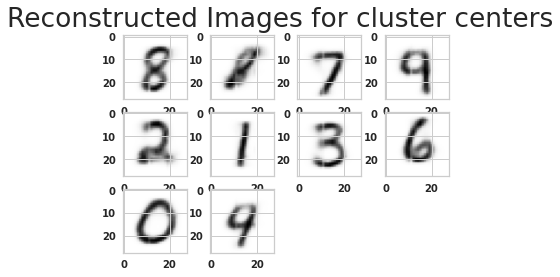

In [ ]:
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if  not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])
    posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])   
   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [ ]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [8, -1, 7, -1,
                                               2, 1, 3, 6,
                                               0, -1
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8, 0, 0.8, 0,
                                                   0.8, 0.9, 0.8, 0.8,
                                                   1, 0
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    manual_annotation_json["posterior_proba"] = posterior_proba.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


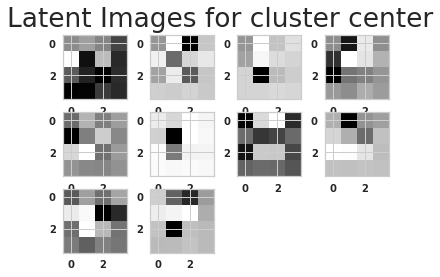

In [ ]:
cluster_centers.shape
cluster_centers_reshaped = np.reshape(cluster_centers, (num_clusters, 4, 4))
cluster_centers_reshaped.shape
display_images(cluster_centers_reshaped, None, "Latent Images for cluster center")

In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])
df[cluster_column_name] = cluster_labels

In [ ]:
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm

cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 


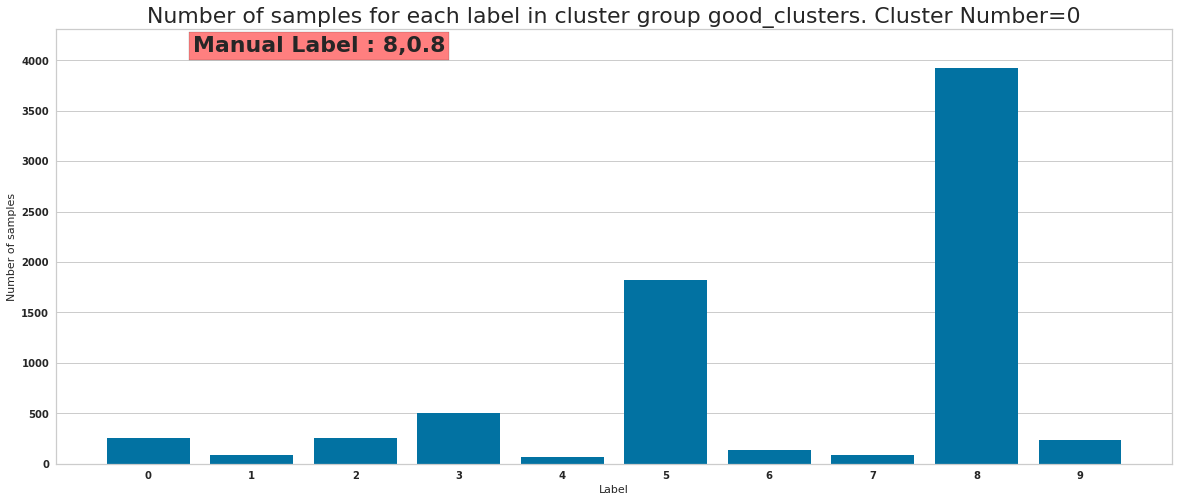

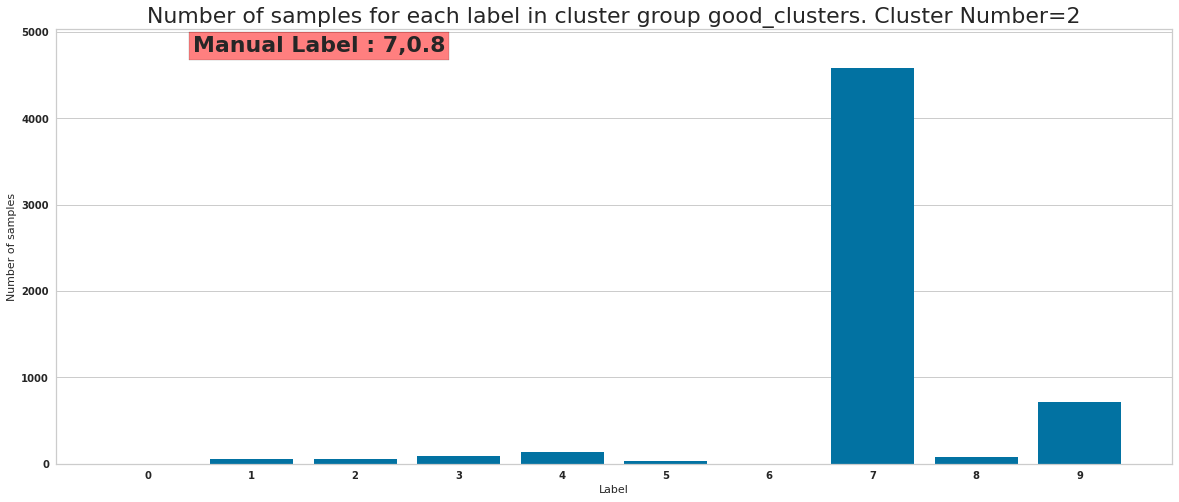

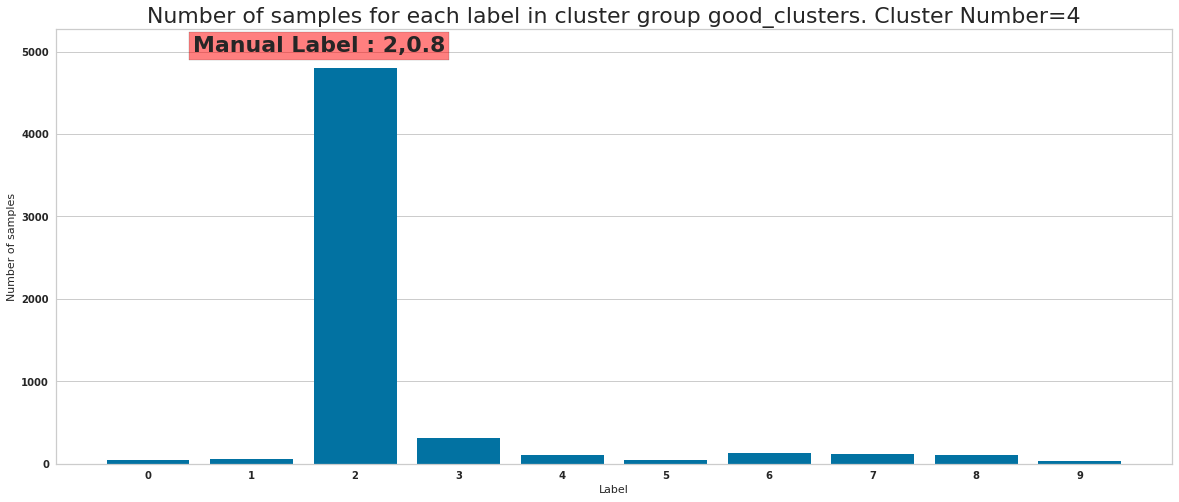

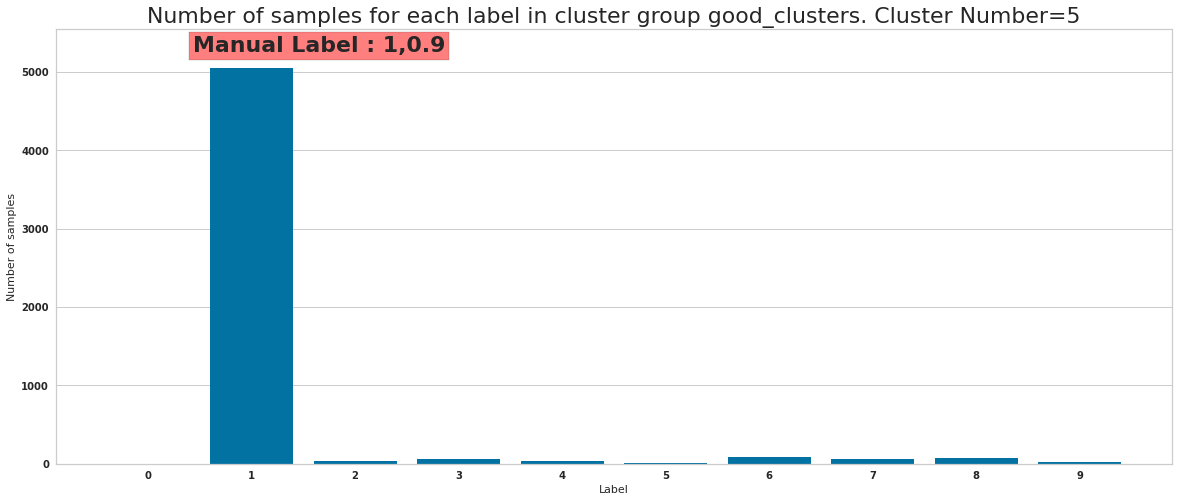

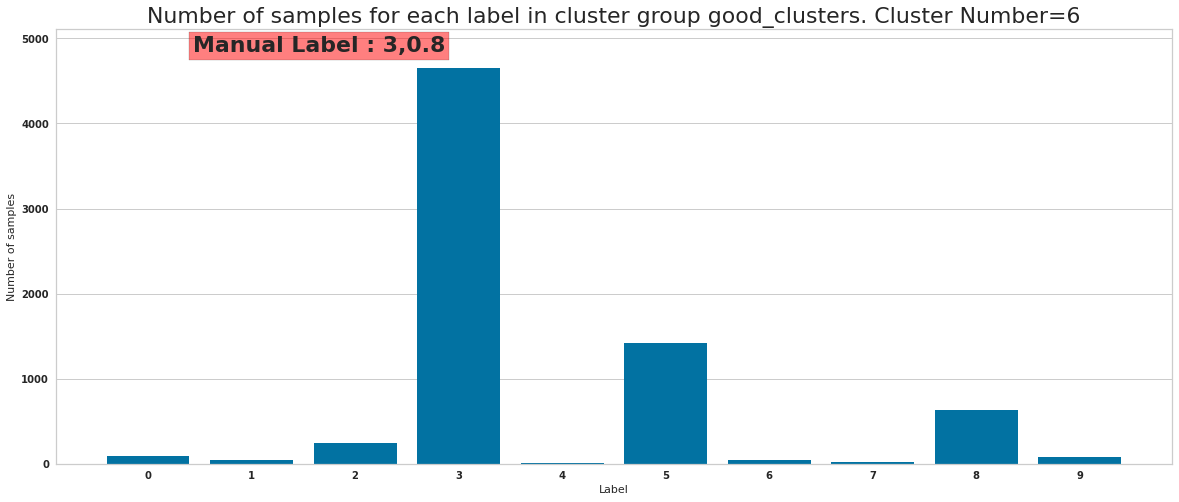

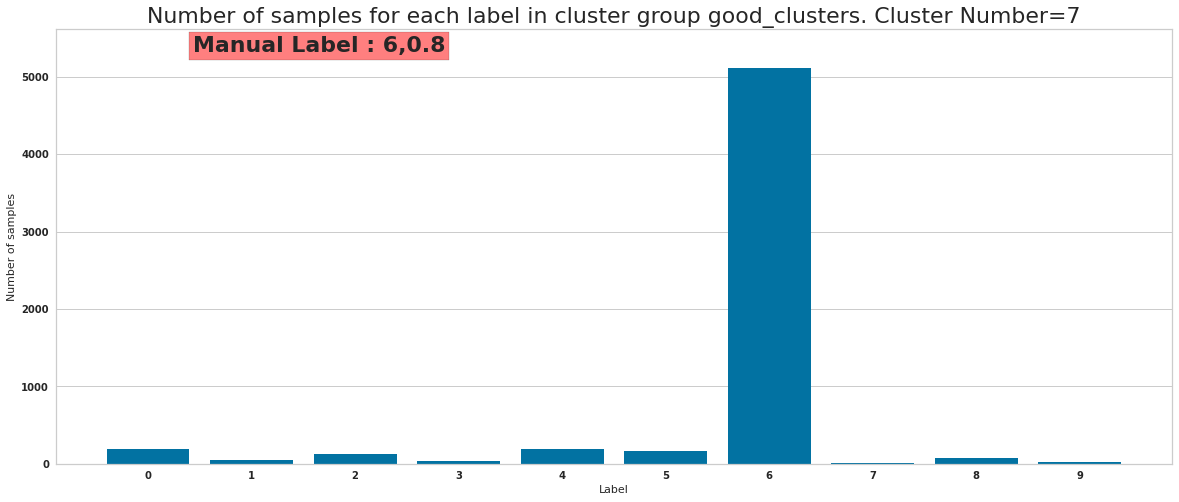

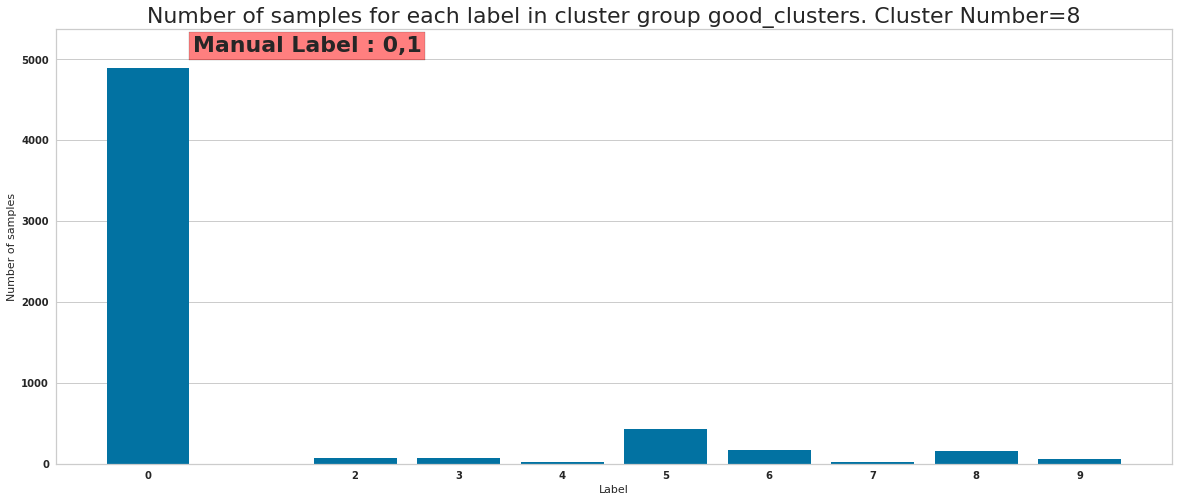

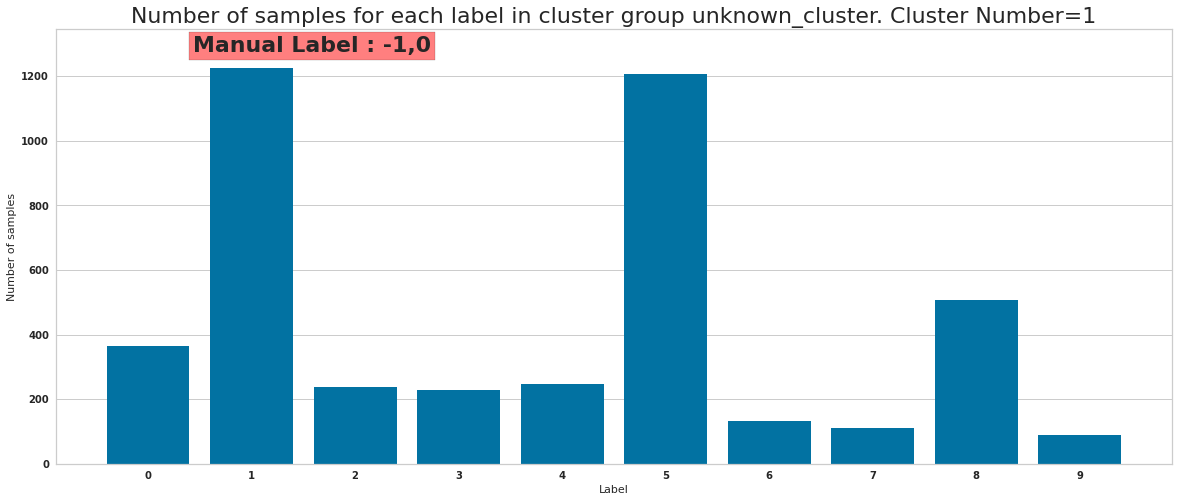

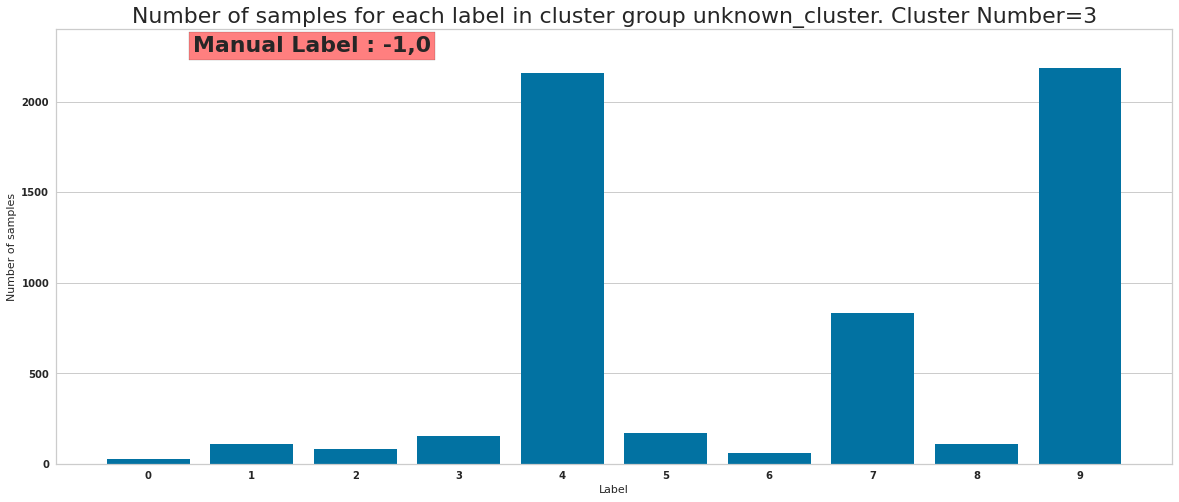

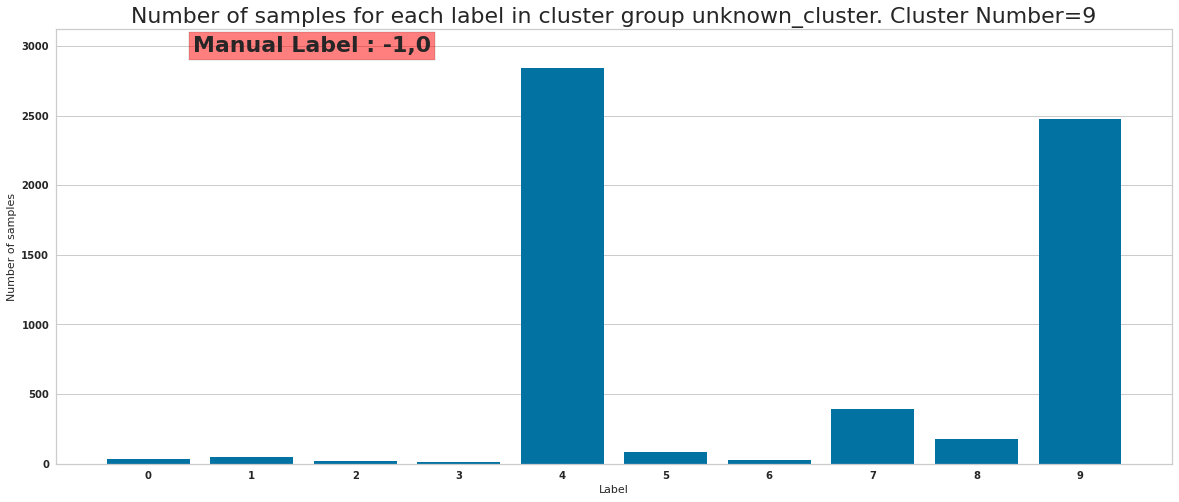

In [ ]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [ ]:
def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(7369, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(4348, 16)
(5738, 16)
(5882, 16)
(5762, 16)
(5442, 16)
(7230, 16)
(5991, 16)
(5899, 16)
(6115, 16)


In [ ]:
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

Posterior probability shape (59776, 10)


In [ ]:
from pandas import DataFrame
from typing import Dict
from clearn.dao.idao import IDao
NUM_IMAGES_IN_SINGLE_PLOT = 12


# Split each of the cluster  into five  clusters, based on the manual label and confidence

1 -1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mod

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

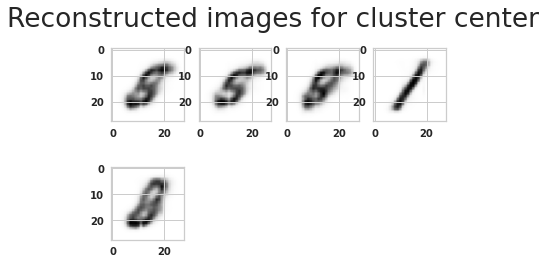

3 -1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mod

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/cluster_centers__level_2_epoch_5.0_cluster_id_3.png


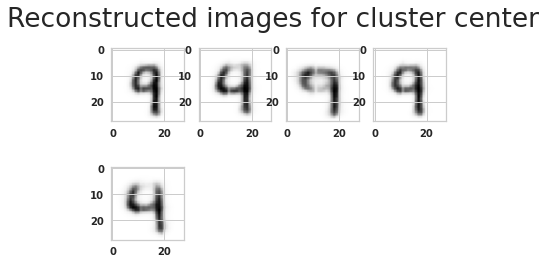

9 -1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mod

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/cluster_centers__level_2_epoch_5.0_cluster_id_9.png


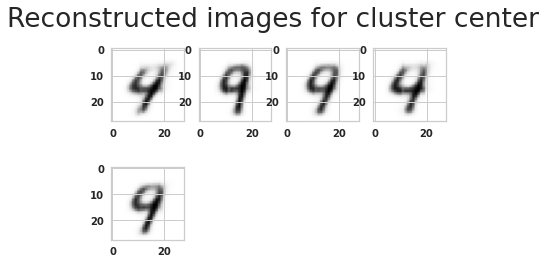

In [ ]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster",
                                                   num_clusters=num_level_2_clusters
                                                   )

In [ ]:
level_2_cluster_dict = level2_manual_annotations[1]
level_2_cluster_dict["manual_labels"] = [
                                         -1, -1, -1, 1,
                                        -1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0.9,
                                              0
                                              ]


level_2_cluster_dict = level2_manual_annotations[3]
level_2_cluster_dict["manual_labels"] = [9, -1, -1, 9,
                                         -1
                                         ]

level_2_cluster_dict["manual_confidences"] = [0.9, 0, 0, 0.9,
                                              0
                                             ]


level_2_cluster_dict = level2_manual_annotations[9]
level_2_cluster_dict["manual_labels"] = [-1, 9, 9, -1,
                                         9
                                         ]
level_2_cluster_dict["manual_confidences"] = [0, 0.8, 0.8, 0,
                                              0.8
                                              ]


#### 9 ###############################################
# level_2_cluster_dict = level2_manual_annotations[9]
# level_2_cluster_dict["manual_labels"] = [-1, 5, -1, -1,
#                                          -1, -1, 5, 1,
#                                          8, -1]
# level_2_cluster_dict["manual_confidences"] =  [0, 0.7, 0, 0,
#                                                0, 0, 0.7, 1,
#                                                0.7, 0]


# level_2_cluster_dict = level2_manual_annotations[8]
# level_2_cluster_dict["manual_labels"] = [-1, -1, 8, 8,
#                                         5, 5, 5, -1,
#                                         8,8
#                                          ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0.9, 0.9,
#                                               0.7, 0.7, 0.7, 0,
#                                               0.9, 0.9
#                                              ]



level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)


In [ ]:
def cluster_level_3_gmm(exp_config: ExperimentConfig,
                           df: DataFrame,
                           cluster_column_name_3,
                           cluster_column_names,
                           parent_cluster_id,
                           model_type,
                           epochs_completed,
                           dao: IDao,
                           cluster_group_dict: Dict[str, ClusterGroup],
                           cluster_type="unknown_cluster",
                           num_clusters=10,
                           classes=list(range(10)),
                           show_images=True,
                        
                           ):
    _, _, z_col_names, _ = get_latent_vector_column(exp_config.Z_DIM)
    level3_manual_annotations = dict()
    print(cluster_column_name_3)
    if cluster_type in cluster_group_dict.keys():
        tf.reset_default_graph()
        for cluster in cluster_group_dict[cluster_type]:
            print(cluster.id, cluster.manual_annotation.label)
            print(cluster_column_names)
            if cluster_type != "unknown_cluster"  and cluster.manual_annotation.label not in classes:
                continue
            #_indices = np.where((df[cluster_column_names[0]] == parent_cluster_id) & (df[cluster_column_names[1]] == cluster.id) )
            _indices = (df[cluster_column_names[0]] == parent_cluster_id) & (df[cluster_column_names[1]] == cluster.id) 
            _df = df.loc[_indices]
            print("indices shape", parent_cluster_id, cluster.id, _df.shape)

            _latent_vectors = _df[z_col_names].values
            
            tf.reset_default_graph()
            _decoded_images, _cluster_centers, _cluster_labels, posterior_proba_level_2 = cluster_and_decode_latent_vectors_gmm(
                model_type,
                num_clusters,
                _latent_vectors,
                exp_config,
                dao
            )
            print(_cluster_labels[0:20])
            df.loc[_indices , cluster_column_name_3] = _cluster_labels
            print(posterior_proba_level_2.shape, _cluster_labels.shape)

            for i in range(num_clusters):
                __indices = np.where( ( df[cluster_column_names[0] ] == parent_cluster_id) & (df[cluster_column_names[1]] == cluster.id) & (df[cluster_column_name_3].values == i))[0]
                df[f"confidence_level_3_{parent_cluster_id}_{cluster.id}_{i}"] = 0
                df.loc[_indices, f"confidence_level_3_{parent_cluster_id}_{cluster.id}_{i}"] = posterior_proba_level_2[:, i]

            image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_3_epoch_{epochs_completed}_cluster_id_{cluster.id}.png"

            if show_images:
                for i in range(0, (num_clusters // NUM_IMAGES_IN_SINGLE_PLOT)  + 1 ):
                    display_images(_decoded_images[i* NUM_IMAGES_IN_SINGLE_PLOT : min( (i + 1) * NUM_IMAGES_IN_SINGLE_PLOT,
                                                                                    num_clusters)],
                                   image_filename,
                                   "Reconstructed images for cluster center",
                                   num_images_to_display = num_clusters
                                )

            # class_labels = widgets.Text(place_holder="-1,-1,-1,-1,-1,-1,-1,-1,-1,-1",
            #     description="Labels")
            # display(class_labels)
            # labels_input = input("Enter the labels in above text box")
            # print(validate_tokenize(labels_input, 10))

            # confidence_input = input("Enter the confidence in above text box")
            # print(validate_tokenize(confidence_input, 10))

            level_3_cluster_dict = dict()
            level_3_cluster_dict["cluster_centers"] = _cluster_centers.tolist()
            level_3_cluster_dict["cluster_labels"] = _cluster_labels.tolist()
            level_3_cluster_dict["decoded_images"] = _decoded_images.tolist()

            level_3_cluster_dict["posterier_prob"] = posterior_proba_level_2.tolist()
            # level_2_cluster_dict["manual_labels"] = validate_tokenize_int(labels_input, 10)
            # level_2_cluster_dict["manual_confidences"] = validate_tokenize_float(confidence_input, 10)
            level3_manual_annotations[cluster.id] = level_3_cluster_dict

    return level3_manual_annotations


In [ ]:

process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name
                              )


Setting  next_level_clusters attribute to each primary cluster
1
3
9
Computing distances from second level cluster centers
1
5
Skipping distance computation for unknown cluster
3 (1320,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


3
5
0 (1430,)
3 (1056,)
Skipping distance computation for unknown cluster
9
5
Skipping distance computation for unknown cluster
1 (1460,)
2 (1249,)
4 (881,)


1
1
<class 'dict'>
cluster_level_3
0 -1
('cluster_level_1', 'cluster_level_2')
indices shape 1 0 (578, 113)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/ex

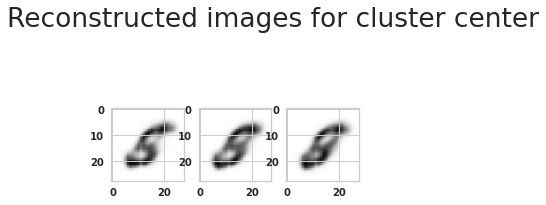

1 -1
('cluster_level_1', 'cluster_level_2')
indices shape 1 1 (852, 116)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_

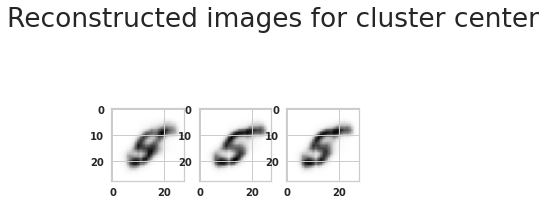

2 -1
('cluster_level_1', 'cluster_level_2')
indices shape 1 2 (657, 119)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_

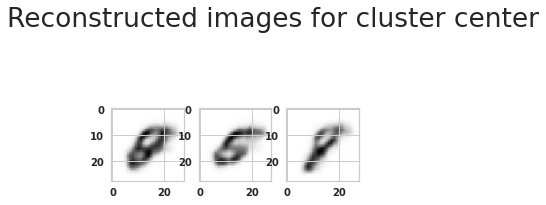

4 -1
('cluster_level_1', 'cluster_level_2')
indices shape 1 4 (941, 122)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_

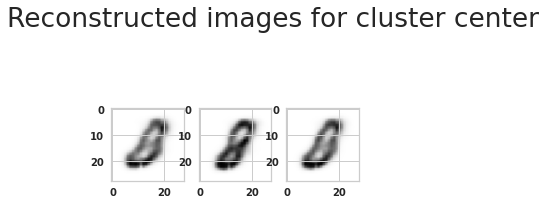

3
3
<class 'dict'>
cluster_level_3
1 -1
('cluster_level_1', 'cluster_level_2')
indices shape 3 1 (967, 125)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/ex

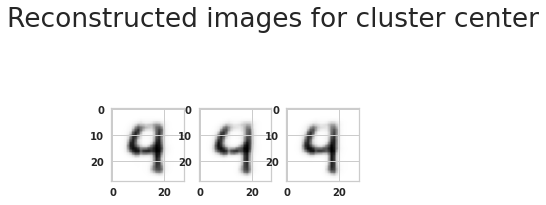

2 -1
('cluster_level_1', 'cluster_level_2')
indices shape 3 2 (1080, 128)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128

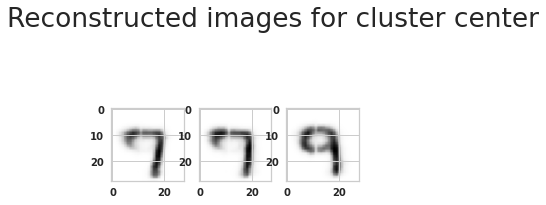

4 -1
('cluster_level_1', 'cluster_level_2')
indices shape 3 4 (1349, 131)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128

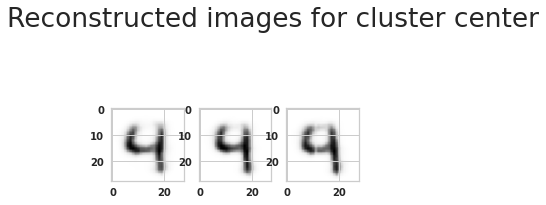

9
9
<class 'dict'>
cluster_level_3
0 -1
('cluster_level_1', 'cluster_level_2')
indices shape 9 0 (1497, 134)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/e

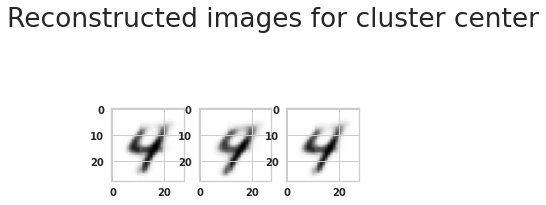

3 -1
('cluster_level_1', 'cluster_level_2')
indices shape 9 3 (1028, 137)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128

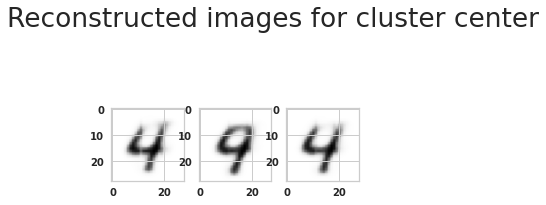

In [ ]:
level_3_annotation_dict = dict()
df[cluster_column_name_3] = -1
for cluster_id in level2_manual_annotations.keys():
    print(cluster_id)
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    print(cluster.id)
    print(type(cluster.next_level_clusters))
    level3_manual_annotations = cluster_level_3_gmm(exp_config,
                                                    df,
                                                    cluster_column_name_3,
                                                    (cluster_column_name, cluster_column_name_2),
                                                    parent_cluster_id = cluster_id,
                                                    model_type=model_type,
                                                    epochs_completed=epochs_completed,
                                                    dao=dao,
                                                    cluster_group_dict = cluster.next_level_clusters,
                                                    cluster_type="unknown_cluster",
                                                    num_clusters=num_level_3_clusters
                                                    )
    level_3_annotation_dict[cluster_id] = level3_manual_annotations
    

In [ ]:
level_3_cluster_dict = level_3_annotation_dict[1][0]
level_3_cluster_dict["manual_labels"] = [-1, -1, -1]
level_3_cluster_dict["manual_confidences"] = [0, 0, 0]

level_3_cluster_dict = level_3_annotation_dict[1][1]
level_3_cluster_dict["manual_labels"] = [-1, -1, -1]
level_3_cluster_dict["manual_confidences"] = [0, 0, 0]


level_3_cluster_dict = level_3_annotation_dict[1][2]
level_3_cluster_dict["manual_labels"] = [-1, -1, -1]
level_3_cluster_dict["manual_confidences"] = [0.7, 0, 0]


level_3_cluster_dict = level_3_annotation_dict[1][4]
level_3_cluster_dict["manual_labels"] = [-1, -1, -1]

level_3_cluster_dict["manual_confidences"] = [0, 0, 0]


level_3_cluster_dict = level_3_annotation_dict[3][1]
level_3_cluster_dict["manual_labels"] = [-1, -1, -1]

level_3_cluster_dict["manual_confidences"] = [0, 0, 0]

level_3_cluster_dict = level_3_annotation_dict[3][2]
level_3_cluster_dict["manual_labels"] = [-1, -1, 9]
level_3_cluster_dict["manual_confidences"] = [0, 0, 0.7]


level_3_cluster_dict = level_3_annotation_dict[3][4]
level_3_cluster_dict["manual_labels"] = [4, 4, -1]
level_3_cluster_dict["manual_confidences"] = [0.7, 0.7, 0]

level_3_cluster_dict = level_3_annotation_dict[9][0]
level_3_cluster_dict["manual_labels"] = [4, -1, 4]
level_3_cluster_dict["manual_confidences"] = [0.8, 0, 0.7]

level_3_cluster_dict = level_3_annotation_dict[9][3]
level_3_cluster_dict["manual_labels"] = [4, -1, 4]
level_3_cluster_dict["manual_confidences"] = [0.8, 0, 0.7]


(59776,)
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist

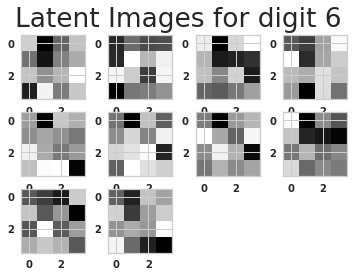

Number of image is 5896. Displaying only first 10 images 


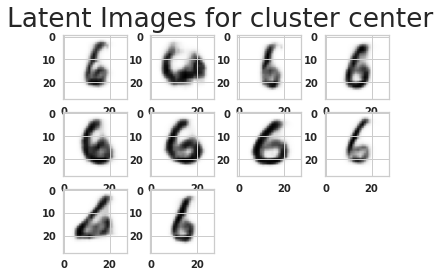

Number of image is 5896. Displaying only first 10 images 


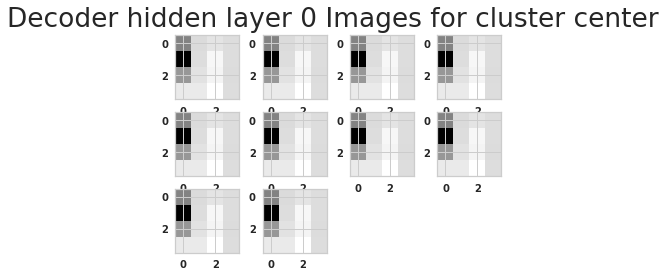

Number of image is 5896. Displaying only first 10 images 


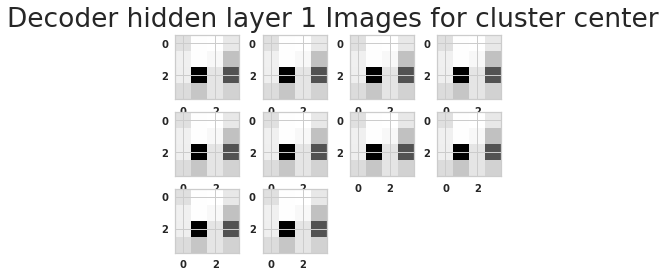

Number of image is 5896. Displaying only first 10 images 


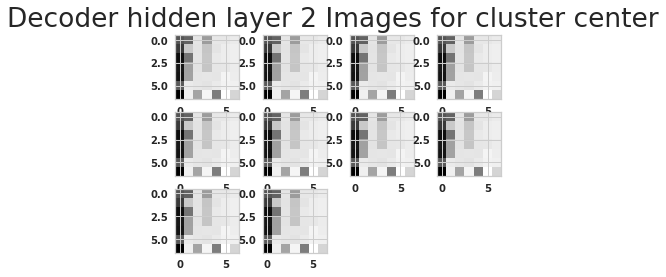

Number of image is 5896. Displaying only first 10 images 


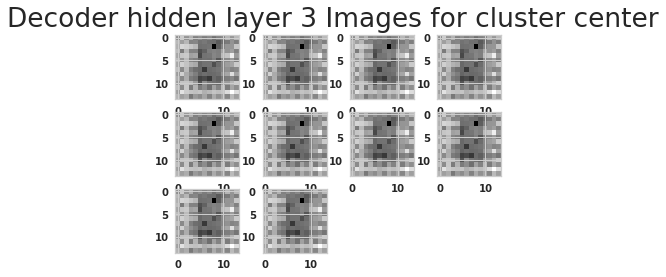

In [ ]:
categorical_labels = np.argmax(labels, axis=1)
print(categorical_labels.shape)
indices = categorical_labels==6
latent_vectors_6 = latent_vectors[indices]
latent_vectors_6.shape
latent_vectors_6_reshaped = np.reshape(latent_vectors_6, (latent_vectors_6.shape[0], 4, 4))

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
                      exp_config=exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images_6, features_dict = decode_and_get_features(model, latent_vectors_6, exp_config.BATCH_SIZE)

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
                      exp_config=exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    
    tensors = [n.name for n in tf.get_default_graph().as_graph_def().node]
    decoder_params = model.get_decoder_weights_bias()
# layer_num = 3
# for t in tensors:
#   if f"decoder/de_conv_{layer_num}/w" in t:
#     print(t)

display_images(latent_vectors_6_reshaped, None, "Latent Images for digit 6", 10)
display_images(np.squeeze(reconstructed_images_6), None, "Latent Images for cluster center", 10)

for layer_num in range(4):
  display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,2]),
                None,
                f"Decoder hidden layer {layer_num} Images for cluster center",
                10)


In [ ]:
def get_cluster_groups(manual_labels,
                       manual_confidence,
                       cluster_column_name,
                       cluster_centers,
                       cluster_labels,
                       df,
                       parent_indices=None,
                       level=1,
                       parent_cluster_id = None):
    """
    Create groups of clusters based on manual label given to each cluster. Different categories of cluster group are

    1. impure
    Contains impure clusters. impure cluster is a cluster where the cluster center have similarity with multiple labels,
    each with different confidence
    2. unknown
    The user who annotated the label doesn't know the label, or it is an invalid data for the domain under consideration
    3. similar_labels
    There are multiple clusters in the cluster group all of which has similar label

    4. good_clusters
    There are multiple clusters all with different labels each with a different confidence level greater than  threshold
    4. average_clusters
    There are multiple clusters all with different labels each with a different confidence level around 0.5
    5. low_confidence_clusters
    There are multiple clusters all with different labels each with a different confidence level close to zero
    """
    # annotation_string = "pure_cluster:Cluster number: {}\nCluster center label:{}\n Confidence: {}"

    cluster_groups_dict = dict()
    for cluster_num, cluster_center_label in enumerate(manual_labels):
        if parent_cluster_id is not None:
            name = f"cluster_{parent_cluster_id}_{cluster_num}"
        else:
            name = f"cluster_{cluster_num}"
        print(cluster_center_label, name)
        if parent_indices is None:
            _df = get_samples_for_cluster(df, cluster_num, cluster_column_name)
            indices = np.where(df[cluster_column_name].values == cluster_num)
        else:
            _df = get_samples_for_cluster(df.iloc[parent_indices], cluster_num, cluster_column_name)
            indices = np.where(df[cluster_column_name].iloc[parent_indices].values == cluster_num)

        cluster_details = {
            "cluster_centers": cluster_centers[cluster_num],
            "cluster_labels": cluster_labels,
            "indices": indices,  # Indices of this cluster elements in parent DataFrame
            "cluster_data_frame": _df,
            "whole_data_frame": df
        }
        if isinstance(cluster_center_label, tuple) or isinstance(cluster_center_label, list):
            # impure cluster
            # create an impure clusterGroup
            manual_annotation = ManualAnnotation(cluster_center_label,
                                                 manual_confidence[cluster_num])
            cluster = Cluster(cluster_id=cluster_num,
                              name=name,
                              cluster_details=cluster_details,
                              level=level,
                              manual_annotation=manual_annotation)
            if "impure_cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["impure_cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["impure_cluster"] = ClusterGroup("impure_cluster", [cluster])
        elif cluster_center_label == -1:
            # unknown cluster
            manual_annotation = ManualAnnotation(cluster_center_label, manual_confidence[cluster_num])

            cluster = Cluster(cluster_id=cluster_num,
                              name=name,
                              cluster_details=cluster_details,
                              level=level,
                              manual_annotation=manual_annotation
                              )
            if "unknown_cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["unknown_cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["unknown_cluster"] = ClusterGroup("unknown_cluster", [cluster])
            # unknown cluster
        else:
            # good/average/low confidence
            manual_annotation = ManualAnnotation(cluster_center_label, manual_confidence[cluster_num])
            cluster = Cluster(cluster_id=cluster_num,
                              name=name,
                              cluster_details=cluster_details,
                              level=level,
                              manual_annotation=manual_annotation)
            cluster_group_label = manual_annotation.get_label()
            if cluster_group_label in cluster_groups_dict.keys():
                cluster_groups_dict[cluster_group_label].add_cluster(cluster)
            else:
                cluster_groups_dict[cluster_group_label] = ClusterGroup(cluster_group_label,
                                                                        [cluster])
    return cluster_groups_dict


In [ ]:
from scipy.spatial.distance import mahalanobis

def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)

def compute_distance_level_3(df,
                             parent_cluster_id,
                             num_level_3_clusters,
                             cluster_column_names,
                             z_col_names,
                             cluster,
                             cluster_column_name_2):
    for i in range(num_level_3_clusters):
        df[f"distance_level_3_{parent_cluster_id}_{cluster.id}_{i}"] = 100000

    for cluster_group_label, level_3_cluster_group in cluster.next_level_clusters.items():
        print(cluster_group_label)
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        print(cluster_column_names,cluster_column_name_2 )
        print(f"parent_cluster_id={parent_cluster_id}, level_2_cluster_id={cluster.id}")
        for level_3_cluster in level_3_cluster_group:
            print("level 3 cluster id ",level_3_cluster.id)
            indices = np.where((df[cluster_column_names[0]].values == parent_cluster_id) &
                               (df[cluster_column_names[1]].values == cluster.id) &
                               (df[cluster_column_name_2].values == level_3_cluster.id) )[0]
            cluster_centers_level_3 = level_3_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            print("lv shape",lv.shape)
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_3_cluster.id, indices.shape)
            df[f"distance_level_3_{parent_cluster_id}_{cluster.id}_{level_3_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_3,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [ ]:
import scipy as sp

def process_third_level_clusters(df,
                                  cluster_group_dict,
                                  level3_manual_annotations_dict,
                                  z_col_names,
                                  cluster_column_name_3,
                                  cluster_column_name_2,
                                  cluster_column_name):
    print("Setting  next_level_clusters attribute to each primary cluster")
    for parent_cluster_id in level3_manual_annotations_dict.keys():
        #print(parent_cluster_id)
        for level_2_cluster_id in level3_manual_annotations_dict[parent_cluster_id].keys():
            _cluster_centers = level3_manual_annotations_dict[parent_cluster_id][level_2_cluster_id]["cluster_centers"]
            _cluster_labels = level3_manual_annotations_dict[parent_cluster_id][level_2_cluster_id]["cluster_labels"]

            print(f"parent_cluster_id={parent_cluster_id}, level_2_cluster_id={level_2_cluster_id}")
            level_3_cluster_dict = level3_manual_annotations_dict[parent_cluster_id][level_2_cluster_id]
            _indices = np.where((df[cluster_column_name].values == parent_cluster_id ) & (df[cluster_column_name_2].values == level_2_cluster_id) )
            
            print(level_3_cluster_dict["manual_labels"])

            cluster_level_3_group_dict = get_cluster_groups(level_3_cluster_dict["manual_labels"],
                                                            level_3_cluster_dict["manual_confidences"],
                                                            cluster_column_name_3,
                                                            _cluster_centers,
                                                            _cluster_labels,
                                                            df,
                                                            _indices,
                                                            parent_cluster_id=f"{parent_cluster_id}_{level_2_cluster_id}"
                                                            )
            _, cluster = get_cluster(parent_cluster_id, cluster_group_dict)
            _, level_2_cluster = get_cluster(level_2_cluster_id, cluster.next_level_clusters)
            level_2_cluster.set_next_level_clusters(cluster_level_3_group_dict)

    print("Computing distances from third level cluster centers")
    for parent_cluster_id in level3_manual_annotations_dict.keys():
        for level_2_cluster_id in level3_manual_annotations_dict[parent_cluster_id].keys():
            _cluster_centers = level3_manual_annotations_dict[parent_cluster_id][level_2_cluster_id]["cluster_centers"]
            _cluster_labels = level3_manual_annotations_dict[parent_cluster_id][level_2_cluster_id]["cluster_labels"]

            #print(f"parent_cluster_id={parent_cluster_id}, level_2_cluster_id={level_2_cluster_id}")
            _, cluster = get_cluster(parent_cluster_id, cluster_group_dict)
            _, level_2_cluster = get_cluster(level_2_cluster_id, cluster.next_level_clusters)


            num_level_3_clusters = level_2_cluster.next_lever_cluster_count()
            compute_distance_level_3(df,
                                     parent_cluster_id,
                                     num_level_3_clusters, 
                                     (cluster_column_name, cluster_column_name_2),
                                     z_col_names,
                                     level_2_cluster,
                                    cluster_column_name_3)


In [ ]:
process_third_level_clusters(df,
                                  cluster_group_dict,
                                  level_3_annotation_dict,
                                  z_col_names,
                             cluster_column_name_3,
                                  cluster_column_name_2,
                              cluster_column_name
                              )


Setting  next_level_clusters attribute to each primary cluster
parent_cluster_id=1, level_2_cluster_id=0
[-1, -1, -1]
-1 cluster_1_0_0
-1 cluster_1_0_1
-1 cluster_1_0_2
parent_cluster_id=1, level_2_cluster_id=1
[-1, -1, -1]
-1 cluster_1_1_0
-1 cluster_1_1_1
-1 cluster_1_1_2
parent_cluster_id=1, level_2_cluster_id=2
[-1, -1, -1]
-1 cluster_1_2_0
-1 cluster_1_2_1
-1 cluster_1_2_2
parent_cluster_id=1, level_2_cluster_id=4
[-1, -1, -1]
-1 cluster_1_4_0
-1 cluster_1_4_1
-1 cluster_1_4_2
parent_cluster_id=3, level_2_cluster_id=1
[-1, -1, -1]
-1 cluster_3_1_0
-1 cluster_3_1_1
-1 cluster_3_1_2
parent_cluster_id=3, level_2_cluster_id=2
[-1, -1, 9]
-1 cluster_3_2_0
-1 cluster_3_2_1
9 cluster_3_2_2
parent_cluster_id=3, level_2_cluster_id=4
[4, 4, -1]
4 cluster_3_4_0
4 cluster_3_4_1
-1 cluster_3_4_2
parent_cluster_id=9, level_2_cluster_id=0
[4, -1, 4]
4 cluster_9_0_0
-1 cluster_9_0_1
4 cluster_9_0_2
parent_cluster_id=9, level_2_cluster_id=3
[4, -1, 4]
4 cluster_9_3_0
-1 cluster_9_3_1
4 cluster_9_3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


good_clusters
('cluster_level_1', 'cluster_level_2') cluster_level_3
parent_cluster_id=3, level_2_cluster_id=4
level 3 cluster id  0
lv shape (446, 16)
0 (446,)
level 3 cluster id  1
lv shape (391, 16)
1 (391,)
unknown_cluster
Skipping distance computation for unknown cluster
good_clusters
('cluster_level_1', 'cluster_level_2') cluster_level_3
parent_cluster_id=9, level_2_cluster_id=0
level 3 cluster id  0
lv shape (497, 16)
0 (497,)
level 3 cluster id  2
lv shape (403, 16)
2 (403,)
unknown_cluster
Skipping distance computation for unknown cluster
good_clusters
('cluster_level_1', 'cluster_level_2') cluster_level_3
parent_cluster_id=9, level_2_cluster_id=3
level 3 cluster id  0
lv shape (279, 16)
0 (279,)
level 3 cluster id  2
lv shape (356, 16)
2 (356,)
unknown_cluster
Skipping distance computation for unknown cluster


In [ ]:

def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       cluster_column_name_3,
                                       assign_only_correct=False,
                                       estimate_type="distance_function"
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        if estimate_type == "distance_function":
            _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
            dst = _distance_df.iloc[_indices]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
            _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        elif estimate_type == "map":
            _confidence_df = df[f"confidence_level_2_{cluster.id}_{_cluster.id}"]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * _confidence_df.iloc[_indices]
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0
    def assign_label_3(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id)
                            & (_df[cluster_column_name_3].values == level_3_cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        if estimate_type == "distance_function":
            _distance_df = df[f"distance_level_3_{cluster.id}_{_cluster.id}_{level_3_cluster.id}"]
            dst = _distance_df.iloc[_indices]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
            _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        elif estimate_type == "map":
            _confidence_df = df[f"confidence_level_3_{cluster.id}_{_cluster.id}_{level_3_cluster.id}"]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * _confidence_df.iloc[_indices]
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0
    num_individual_samples_annotated = 0
    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _confidence_df = df[f"confidence_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label

                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)
            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")

            if estimate_type == "distance_function":
                distance_df = df["distance_{}".format(annotate_cluster)]
                dist = distance_df.iloc[indices]
                df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
                df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
            elif estimate_type == "map":
                confidence_df = df["confidence_{}".format(annotate_cluster)]
                df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * confidence_df.iloc[indices]
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
        else:
            print("unknown")
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(cluster.id)

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    print(f"Second level cluster id {_cluster.id}")
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Look at third level cluster
                        for level_2_cluster_group_name, level_2_cluster_group in _cluster.next_level_clusters.items():
                            for level_3_cluster in level_2_cluster_group:
                                print(f"Third level cluster id {level_3_cluster.id}")
                                _manual_label = level_3_cluster.manual_annotation.label
                                print(f"********{_manual_label}*******")
                                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                                    # TODO add this code
                                    pass
                                elif _manual_label != -1:
                                    print("Manual_label", _manual_label)
                                    assign_label_3(df, _manual_label)
                                else:
                                    indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                                       & (df[cluster_column_name_2].values == _cluster.id)
                                                       & (df[cluster_column_name_3].values == level_3_cluster.id))[0]
                                    print(f"Annotating individual samples {indices.shape}")
                                    num_individual_samples_annotated += indices.shape[0]
                                    df["manual_annotation"].iloc[indices] = df["label"][indices].values
                                    df["manual_annotation_confidence"].iloc[indices] = 1
                                    if estimate_type =="distance_function":
                                        _dist = _distance_df.iloc[indices]
                                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)
        print("********************************")

    return num_individual_samples_annotated


In [ ]:
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   cluster_column_name_3,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Manual Label 8
(7369, 170) (7369, 71)
Num correct=3919
Cluster 0 Manual Label 8 Percentage correct 53.182249966074096
********************************
unknown
1
Second level cluster id 0
********-1*******
Third level cluster id 0
********-1*******
Annotating individual samples (234,)
Third level cluster id 1
********-1*******
Annotating individual samples (204,)
Third level cluster id 2
********-1*******
Annotating individual samples (140,)
Second level cluster id 1
********-1*******
Third level cluster id 0
********-1*******
Annotating individual samples (238,)
Third level cluster id 1
********-1*******
Annotating individual samples (361,)
Third level cluster id 2
********-1*******
Annotating individual samples (253,)
Second level cluster id 2
********-1*******
Third level cluster id 0
********-1*******
Annotating individual samples (214,)
Third level cluster id 1
********-1*******
Annotating individual samples (221,)
Third level cluster id 2
********-1*******
Annotating individual sa

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Num correct=6285
Cluster 5 Manual Label 1 Percentage correct 90.79745738225947
********************************
Manual Label 3
(7469, 170) (7230, 71)
Num correct=4885
Cluster 6 Manual Label 3 Percentage correct 65.403668496452
********************************
Manual Label 6
(6129, 170) (5991, 71)
Num correct=5246
Cluster 7 Manual Label 6 Percentage correct 85.593082068853
********************************
Manual Label 0
(6282, 170) (5899, 71)
Num correct=5270
Cluster 8 Manual Label 0 Percentage correct 83.89048073861828
********************************
unknown
9
Second level cluster id 0
********-1*******
Third level cluster id 0
********4*******
Manual_label 4
Third level cluster id 2
********4*******
Manual_label 4
Third level cluster id 1
********-1*******
Annotating individual samples (597,)
Second level cluster id 3
********-1*******
Third level cluster id 0
********4*******
Manual_label 4
Third level cluster id 2
********4*******
Manual_label 4
Third level cluster id 1
********-1*

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
num_individual_samples_annotated

6004

# Save the dataframe with manual annotations

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)

(array([7369., 4348., 5738., 5882., 5762., 5442., 7230., 5991., 5899.,
        6115.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

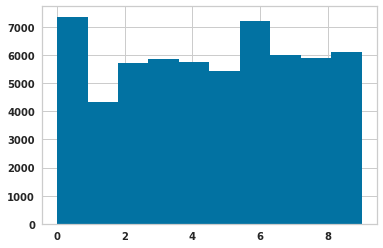

In [ ]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


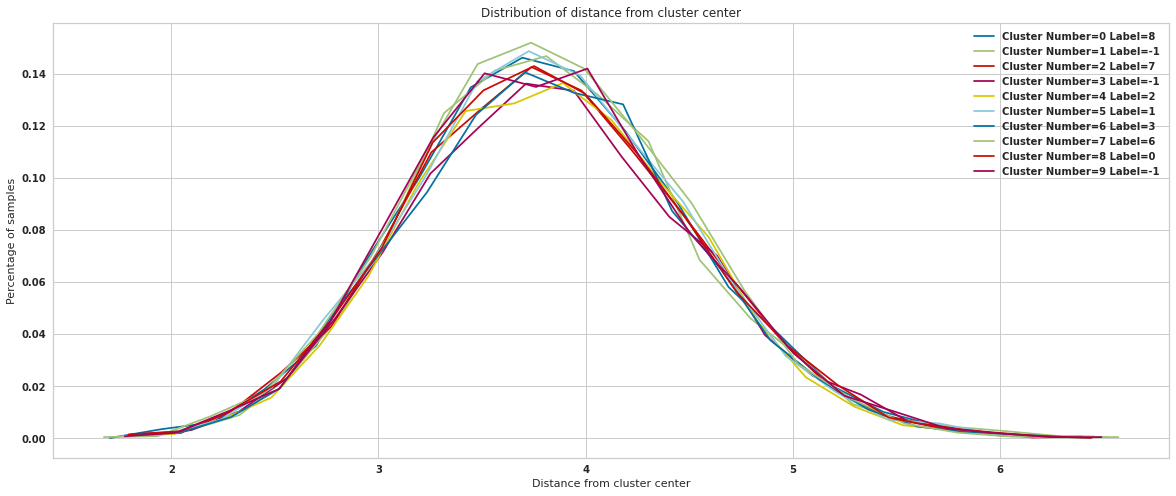

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

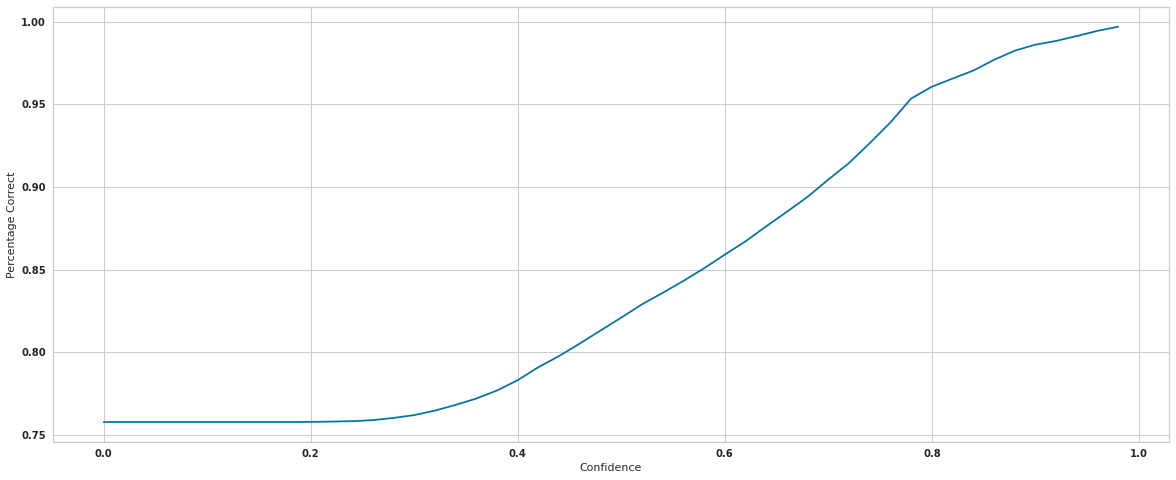

In [ ]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

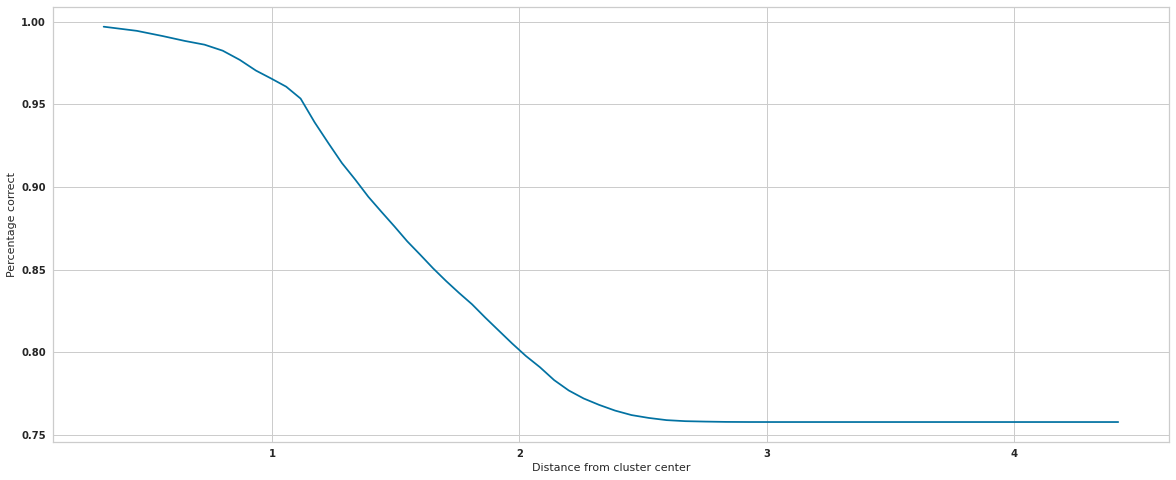

In [ ]:
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_manual_annotation_col_name
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [ ]:
from shutil import copy2

In [ ]:
epochs_completed

5.0

# Update manual annotation in manual annotation file

In [ ]:
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_manual_annotation_col_name, get_overall_label,get_overall_confidence
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

No existing manual annotation file. Creating new manual annotation dataframe
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5


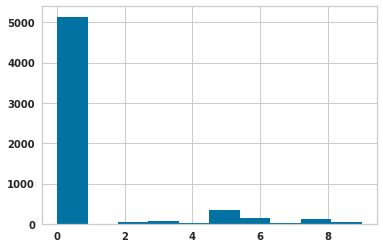

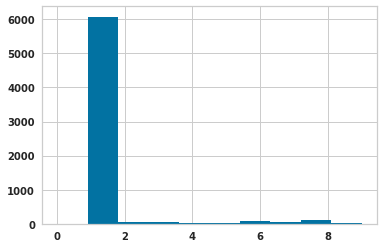

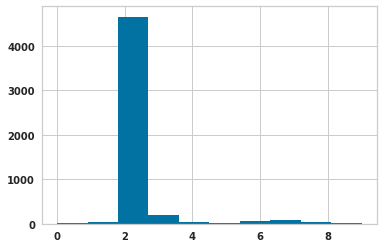

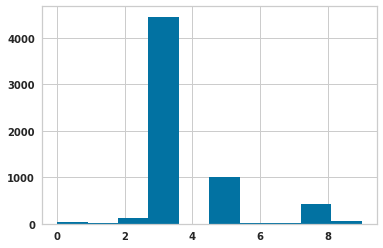

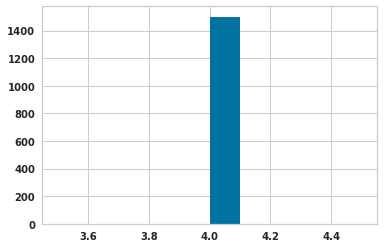

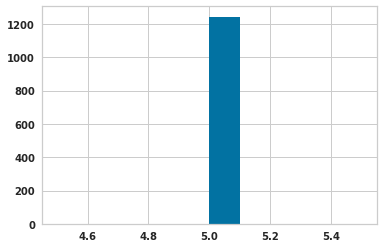

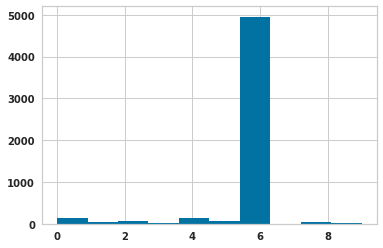

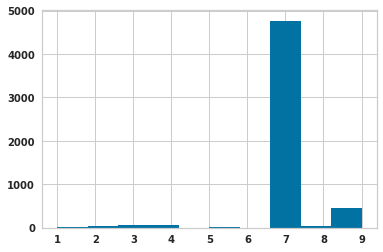

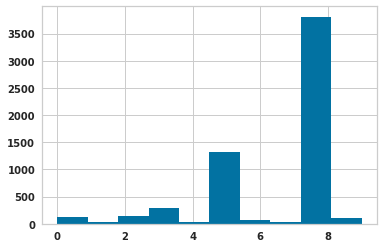

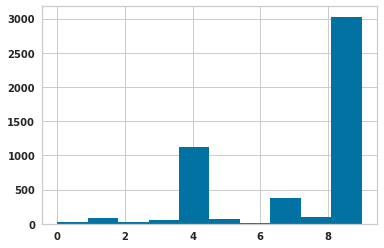

In [ ]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 2

# Get the number of samples annotated

In [ ]:
# num_epochs = int(epochs_completed)


In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

epoch  ...  total_confidence_of_wrong_annotation
0    1.0  ...                                     0
1    2.0  ...                                     0
2    3.0  ...                                     0
3    4.0  ...                                     0
4    5.0  ...                                     0

[5 rows x 13 columns]

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

epoch  ...  total_confidence_of_wrong_annotation
0    1.0  ...                                     0
1    2.0  ...                                     0
2    3.0  ...                                     0
3    4.0  ...                                     0
4    5.0  ...                                     0

[5 rows x 13 columns]

In [ ]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name, index=False)

In [ ]:
from clearn.analysis.cluster_utils import get_num_samples_wrongly_annotated, get_sum_confidence_wrong

In [ ]:
num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()

epoch  ...  total_confidence_of_wrong_annotation
0    1.0  ...                           7848.363856
1    2.0  ...                           7848.363856
2    3.0  ...                           7848.363856
3    4.0  ...                           7848.363856
4    5.0  ...                           7848.363856

[5 rows x 13 columns]

# Start training for one more epoch

In [ ]:
num_epochs += 5
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=exp_config.name,
                                        root_path=root_path,
                                        learning_rate=5e-4,
                                        batch_size=128,
                                        z_dim=exp_config.Z_DIM,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=exp_config.num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units,
                                        strides=exp_config.strides,
                                        num_dense_layers=exp_config.num_dense_layers,
                                        fully_convolutional=exp_config.fully_convolutional,
                                        num_concepts=exp_config.num_concepts,
                                        num_individual_samples_annotated=num_individual_samples_annotated,
                                        num_samples_wrongly_annotated=num_samples_wrongly_annotated,
                                        total_confidence_of_wrong_annotation=total_confidence_of_wrong_annotation,
                                        translate_image=exp_config.translate_image,
                                        uncorrelated_features = exp_config.uncorrelated_features
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [256, 128, 128, 64], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 5, 'Z_DIM': 16, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 128, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0005, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'FULLY_CONVOLUTIONAL': True, 'NUM_CONCEPTS': 20, 'SUPERVISE_WEIG

In [ ]:
num_epochs

10

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-46

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(exp_config.Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=50 z_min=-5.078446 z_max=4.930818
Latent vectors shape (59776, 16)


In [ ]:
print(f"Number of clusters {num_clusters}")

Number of clusters 10


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-46

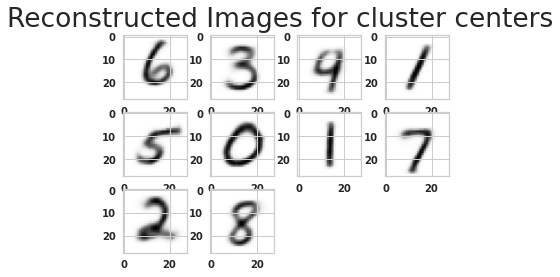

In [ ]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if  not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])
    posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])   
   
    img = Image.open(image_filename)
    img.show()
    

In [ ]:
import json
# TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 3, -1, 1,
                                           5, 0, 1, 7,
                                           2, 8
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.9, 0, 1,
                                               0.8, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [ ]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

6 cluster_0
3 cluster_1
-1 cluster_2
1 cluster_3
5 cluster_4
0 cluster_5
1 cluster_6
7 cluster_7
2 cluster_8
8 cluster_9


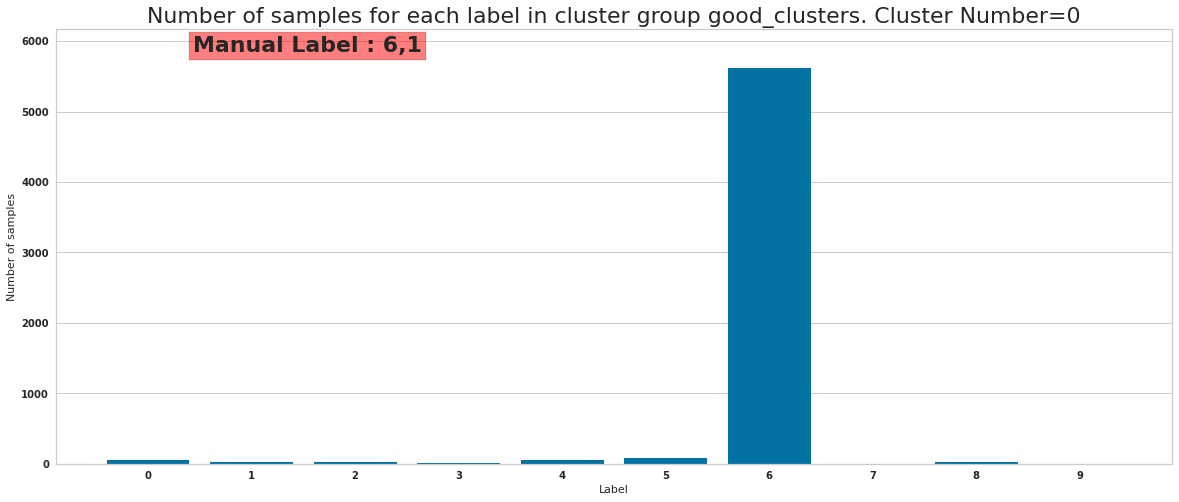

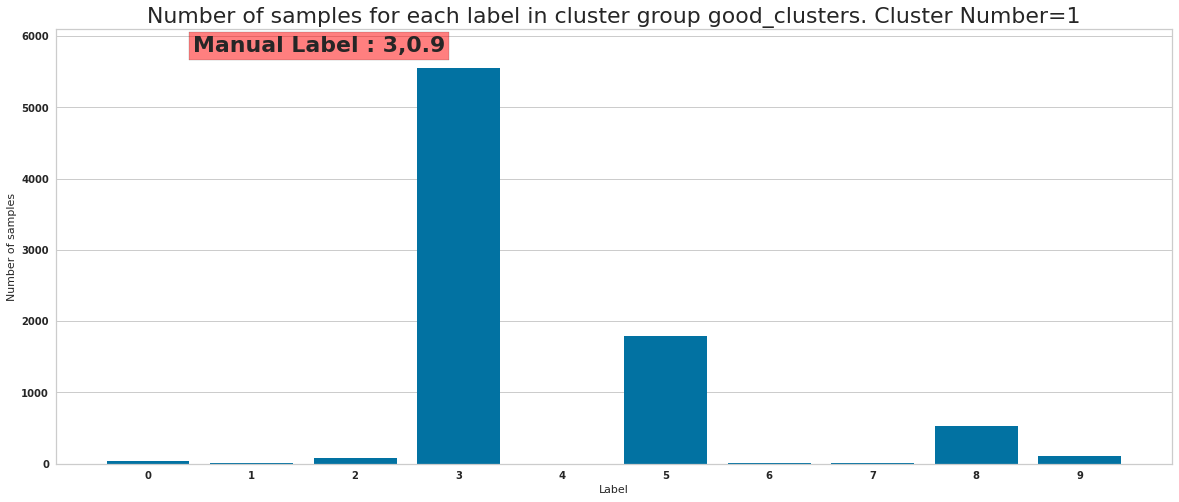

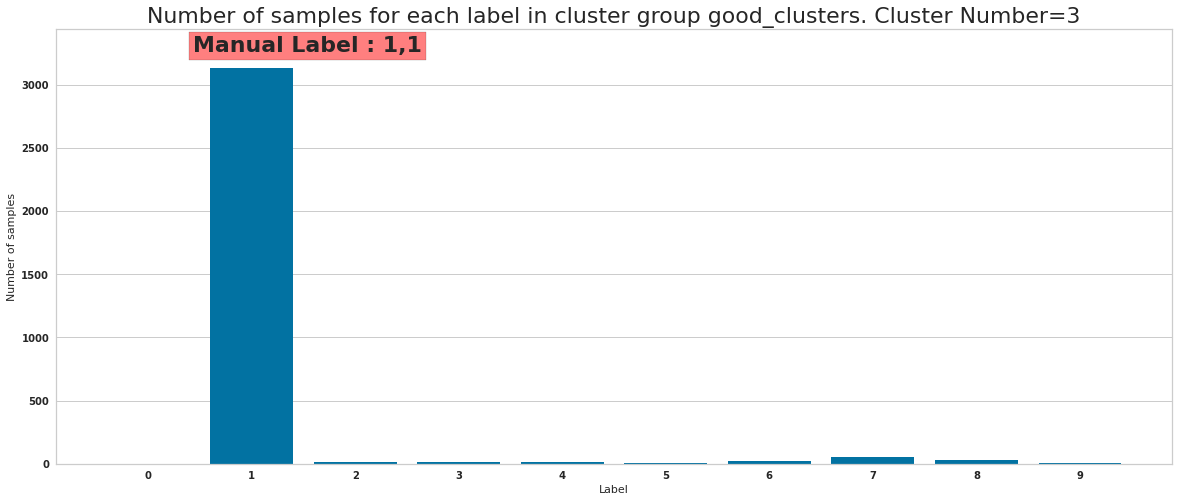

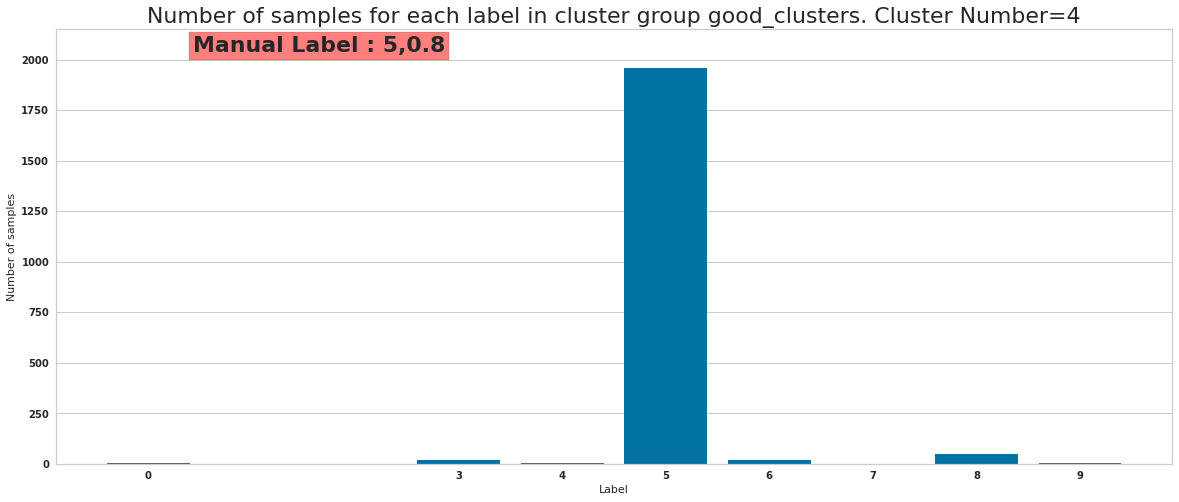

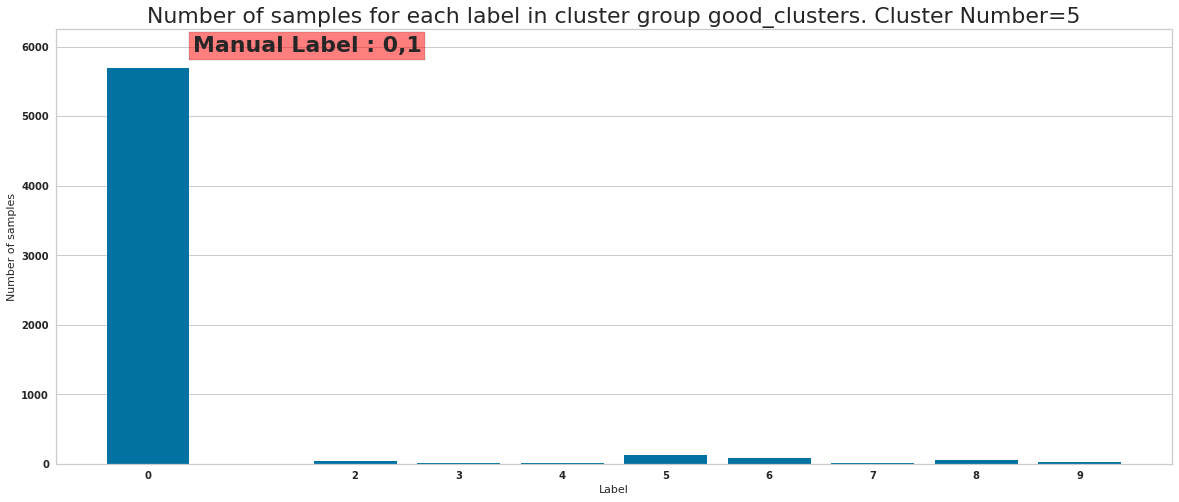

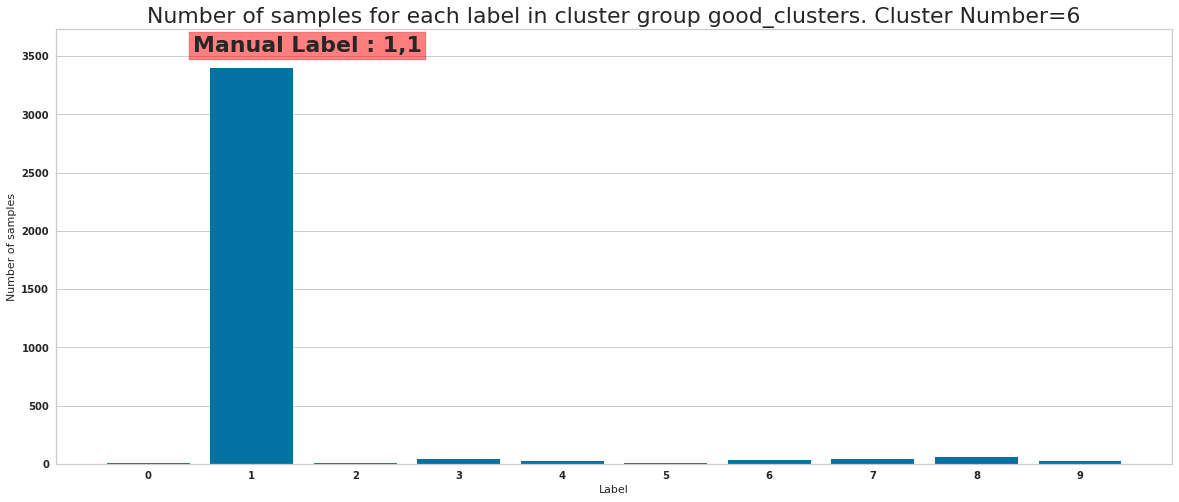

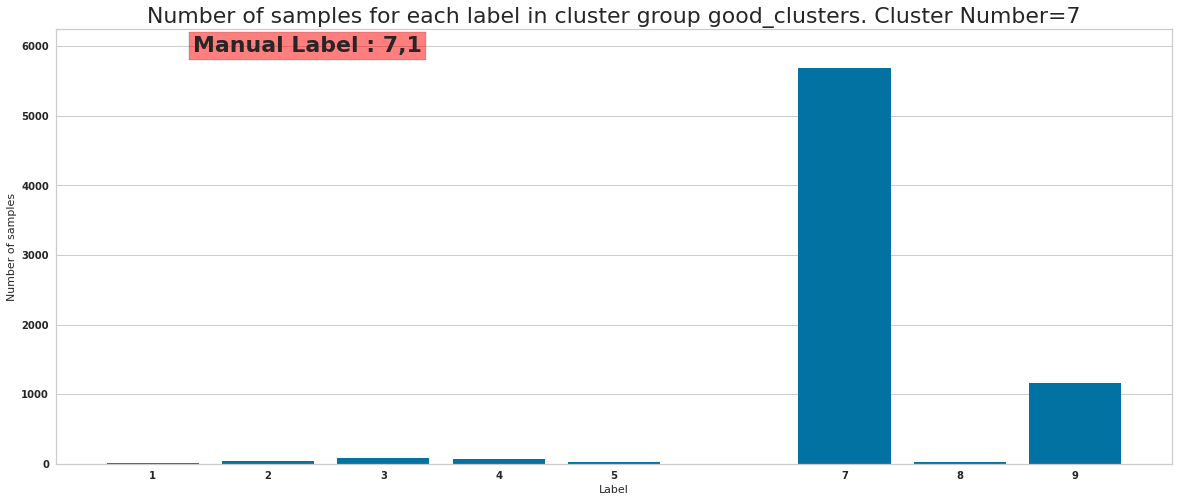

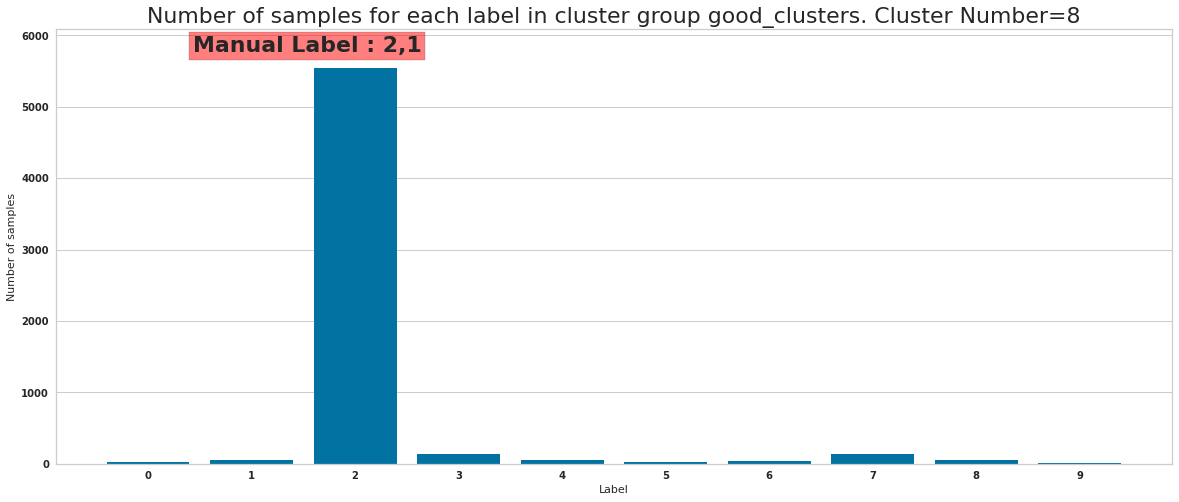

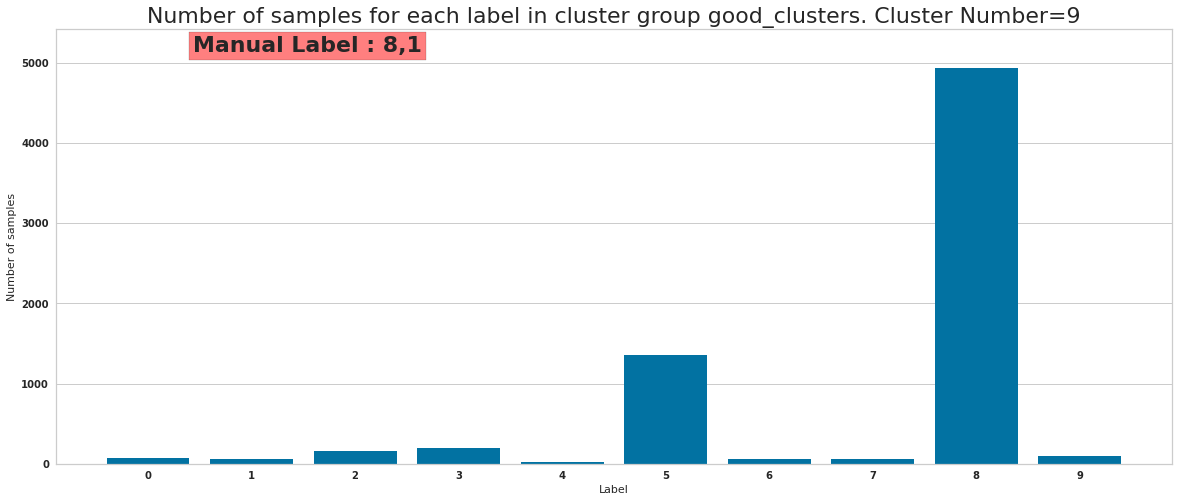

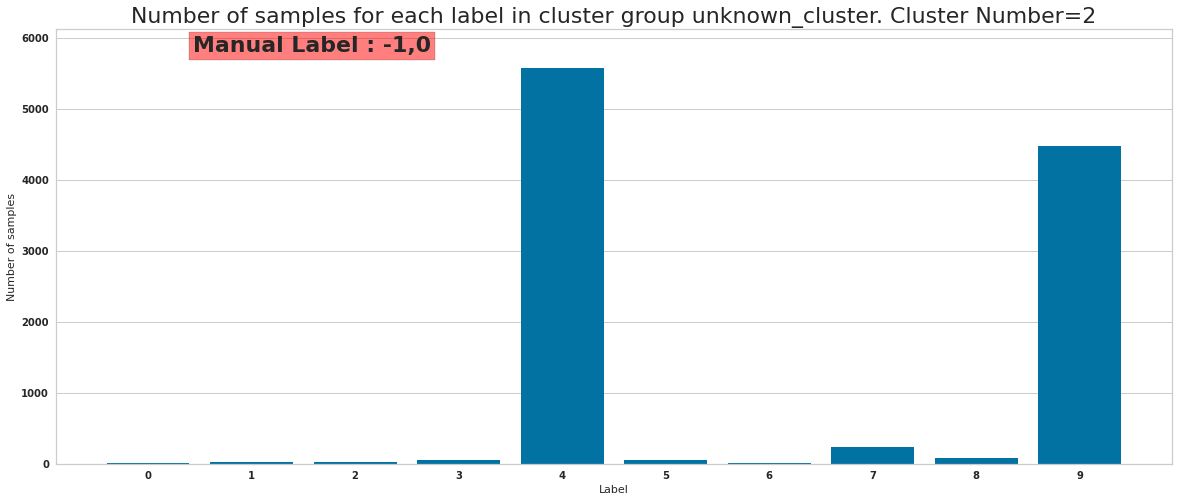

In [ ]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

(5920, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(8124, 16)
(10527, 16)
(3299, 16)
(2061, 16)
(6044, 16)
(3640, 16)
(7085, 16)
(6059, 16)
(7017, 16)
Posterior probability shape (59776, 10)


2 -1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mod

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/cluster_centers__level_2_epoch_10.0_cluster_id_2.png


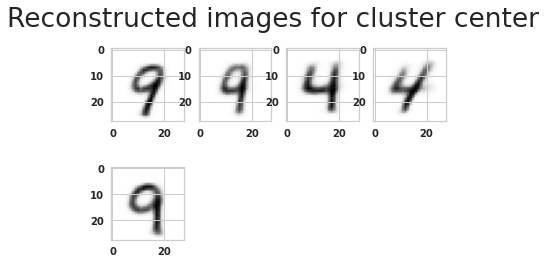

In [ ]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   num_clusters=num_level_2_clusters,
                                                   cluster_type="unknown_cluster"
                                                   )

In [ ]:

# #TODO do this for all unknown clusters

level_2_cluster_dict = level2_manual_annotations[2]
level_2_cluster_dict["manual_labels"] = [
                                        9, 9, 4, 4,
                                        9
                                         ]
level_2_cluster_dict["manual_confidences"] = [
                                              1,  0.8, 0.8, 0.8,
                                              1]



# level_2_cluster_dict = level2_manual_annotations[3]
# level_2_cluster_dict["manual_labels"] = [-1,9,4,-1,
#                                         -1,9,4,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0,0.8,0.7,0,
#                                              0, 0.9, 0.7, 0.9,
#                                              0.7, 0.9]


# level_2_cluster_dict = level2_manual_annotations[4]
# level_2_cluster_dict["manual_labels"] = [9,-1,-1,-1,
#                                         -1,9,9,9,
#                                         9,9]
# level_2_cluster_dict["manual_confidences"] = [0.9,0,0,0,
#                                              0, 0.9, 0.9, 0.9,
#                                              0.9, 0.9]


level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)


In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name
                              )


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   cluster_column_name_3,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
2
Computing distances from second level cluster centers
2
5
0 (2440,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


1 (1707,)
2 (2228,)
3 (2163,)
4 (1989,)
Manual Label 6
(5920, 100) (5920, 61)
Num correct=5611
Cluster 0 Manual Label 6 Percentage correct 94.7804054054054
********************************
Manual Label 3
(8124, 100) (8124, 61)
Num correct=5544
Cluster 1 Manual Label 3 Percentage correct 68.24224519940915
********************************
unknown
2
Second level cluster id 0
********9*******
Manual_label 9
Second level cluster id 1
********9*******
Manual_label 9
Second level cluster id 2
********4*******
Manual_label 4
Second level cluster id 3
********4*******
Manual_label 4
Second level cluster id 4
********9*******
Manual_label 9
********************************
Manual Label 1
(3299, 100) (3299, 61)
Num correct=3129
Cluster 3 Manual Label 1 Percentage correct 94.84692331009397
********************************
Manual Label 5
(2061, 100) (2061, 61)
Num correct=1956
Cluster 4 Manual Label 5 Percentage correct 94.90538573508006
********************************
Manual Label 0
(6044, 100) (

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
num_individual_samples_annotated

0

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)

(array([ 5920.,  8124., 10527.,  3299.,  2061.,  6044.,  3640.,  7085.,
         6059.,  7017.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

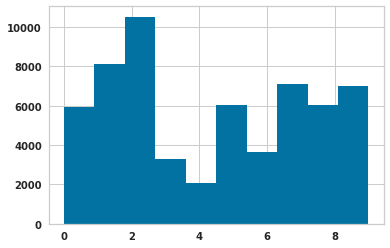

In [ ]:
plt.hist(cluster_labels)

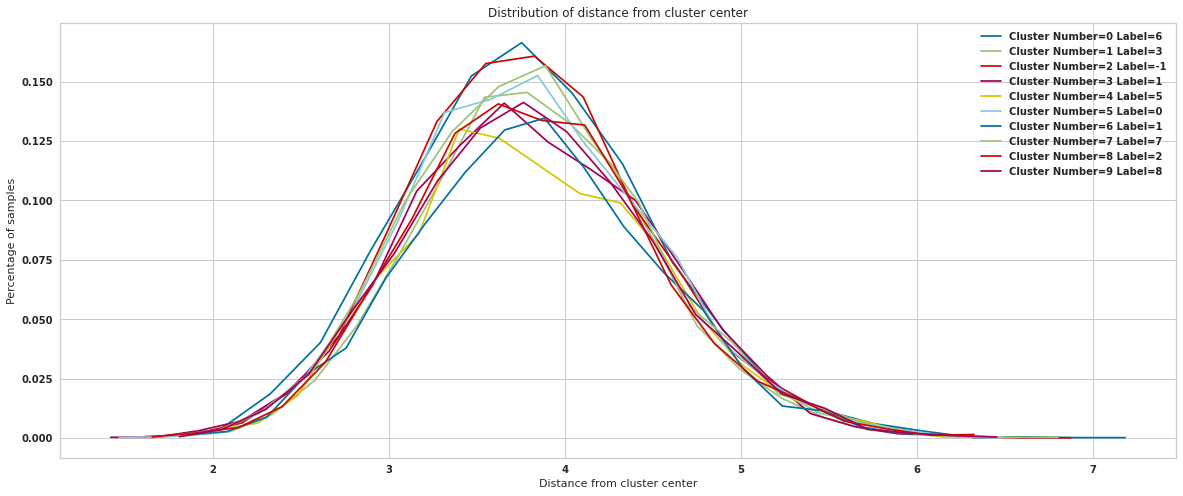

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

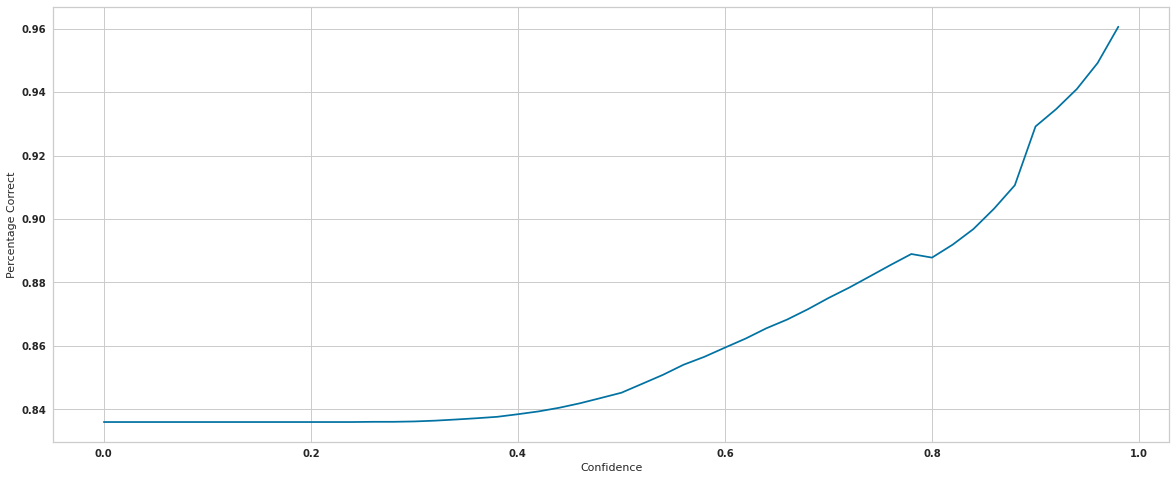

In [ ]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

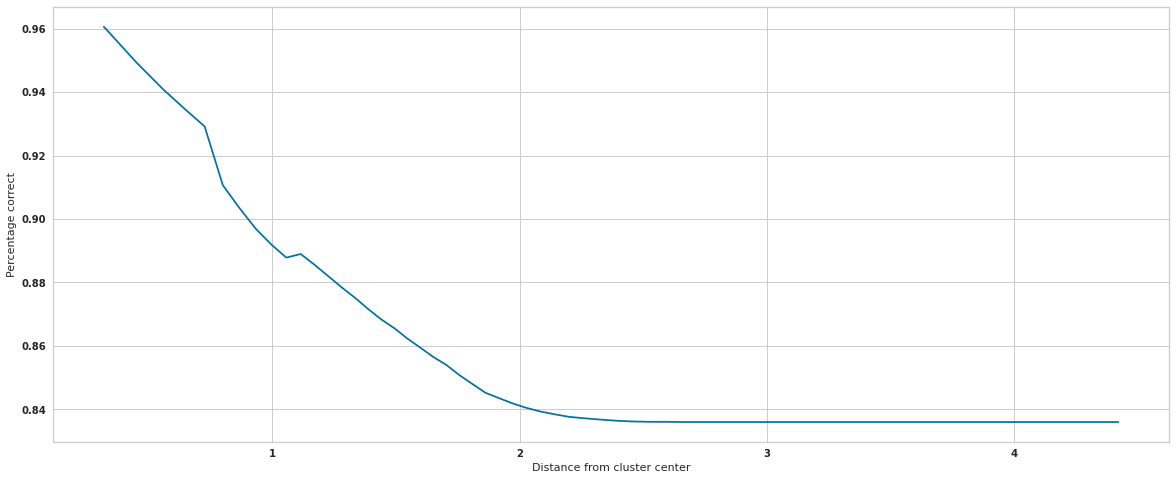

In [ ]:
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_manual_annotation_col_name
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [ ]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6
manual_label_7
manual_label_8
manual_label_9
manual_label_10


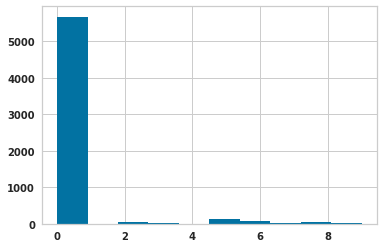

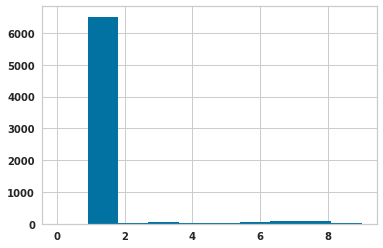

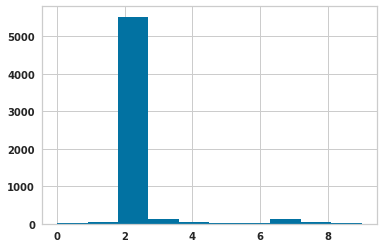

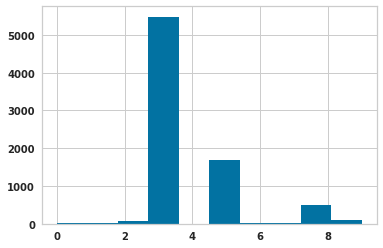

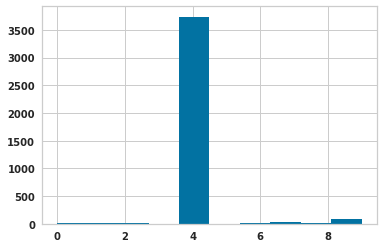

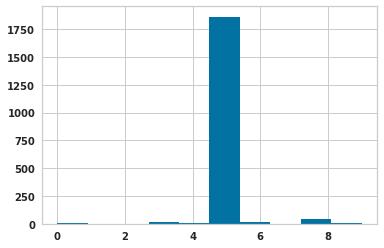

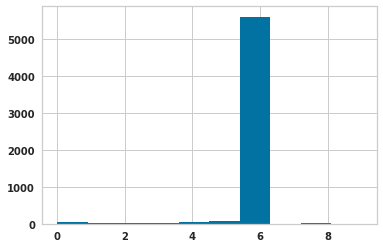

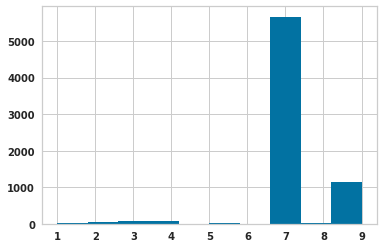

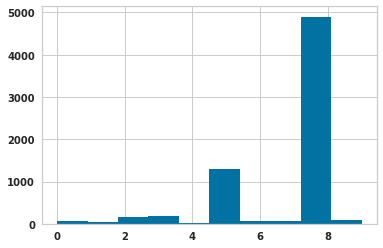

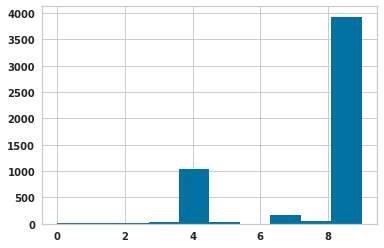

In [ ]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [ ]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs
num_epochs += 5
print(num_epochs)

15


In [ ]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_14.0.csv


In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

# metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
# metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
# metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



#metric_df.head()
#metric_df.to_csv(metric_file)

In [ ]:
print(num_samples_wrongly_annotated,num_individual_samples_annotated, total_confidence_of_wrong_annotation)

9804 0 7566.172830949305


In [ ]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=exp_config.name,
                                        root_path=root_path,
                                        learning_rate=1e-4,
                                        batch_size=128,
                                        z_dim=exp_config.Z_DIM,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=exp_config.num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units,
                                        strides=exp_config.strides,
                                        num_dense_layers=exp_config.num_dense_layers,
                                        fully_convolutional=exp_config.fully_convolutional,
                                        num_concepts=exp_config.num_concepts,
                                        translate_image=exp_config.translate_image,
                                        num_samples_wrongly_annotated=num_samples_wrongly_annotated,
                                        total_confidence_of_wrong_annotation=total_confidence_of_wrong_annotation,
                                        num_individual_samples_annotated=num_individual_samples_annotated,
                                        uncorrelated_features=exp_config.uncorrelated_features
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [256, 128, 128, 64], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 5, 'Z_DIM': 16, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 128, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'FULLY_CONVOLUTIONAL': True, 'NUM_CONCEPTS': 20, 'SUPERVISE_WEIG

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

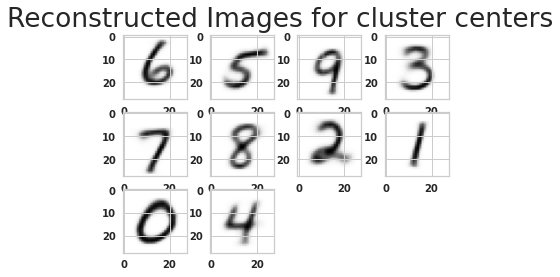

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(exp_config.Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

# if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
#     num_clusters = visualizer.elbow_value_
# else:
#     num_clusters = 2 * visualizer.elbow_value_
# if num_clusters < 10:
#     num_clusters = 10
num_clusters = 10
print(f"Number of clusters {num_clusters}")

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")


In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 5, 9, 3,
                                           7, 8, 2, 1,
                                           0, 4
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 0.9,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


6 cluster_0
5 cluster_1
9 cluster_2
3 cluster_3
7 cluster_4
8 cluster_5
2 cluster_6
1 cluster_7
0 cluster_8
4 cluster_9


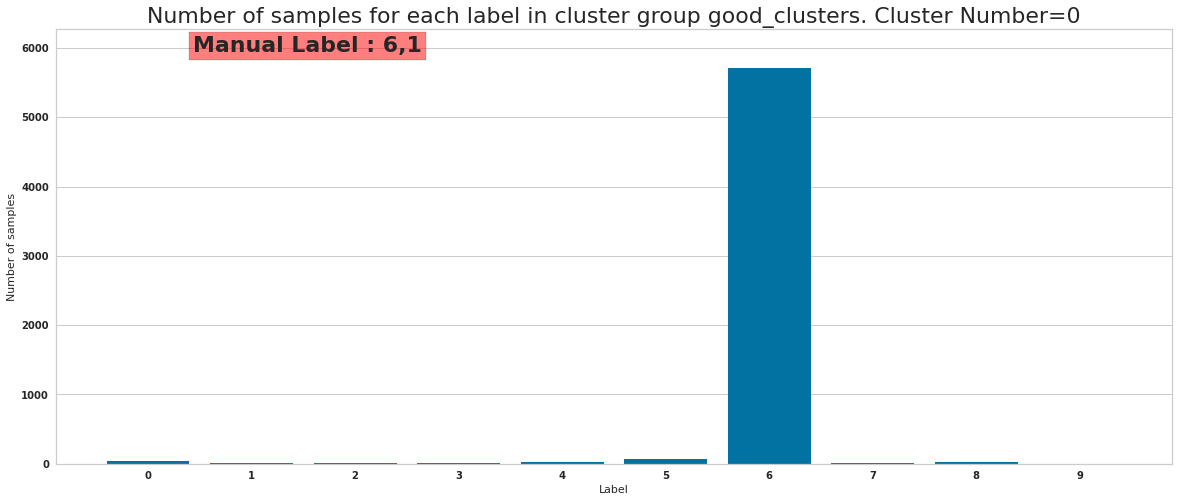

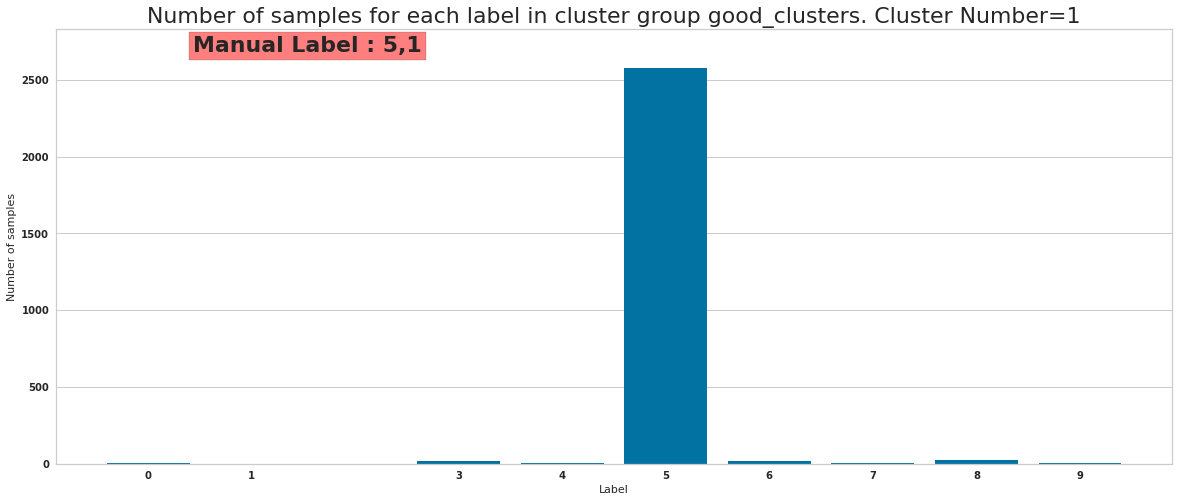

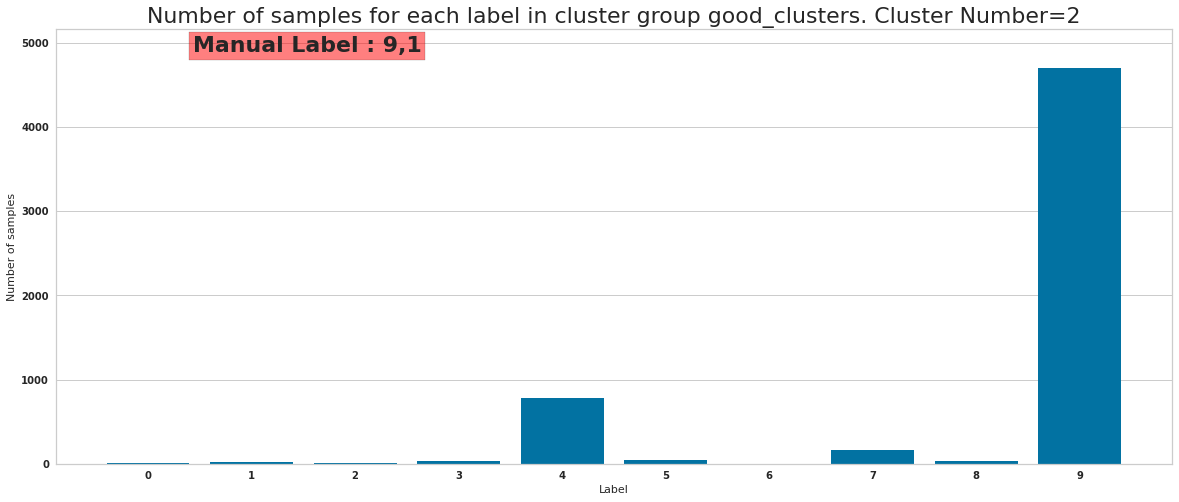

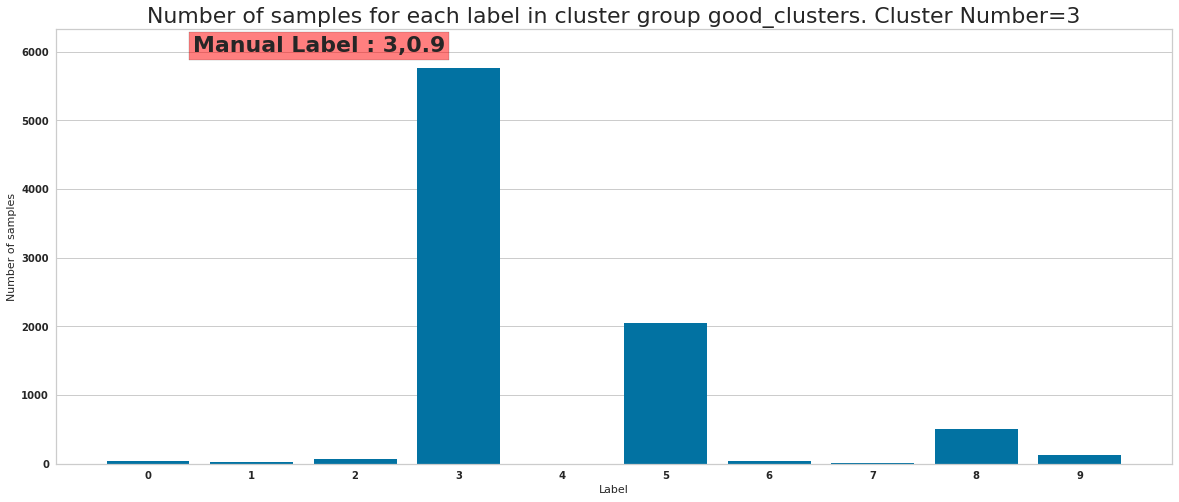

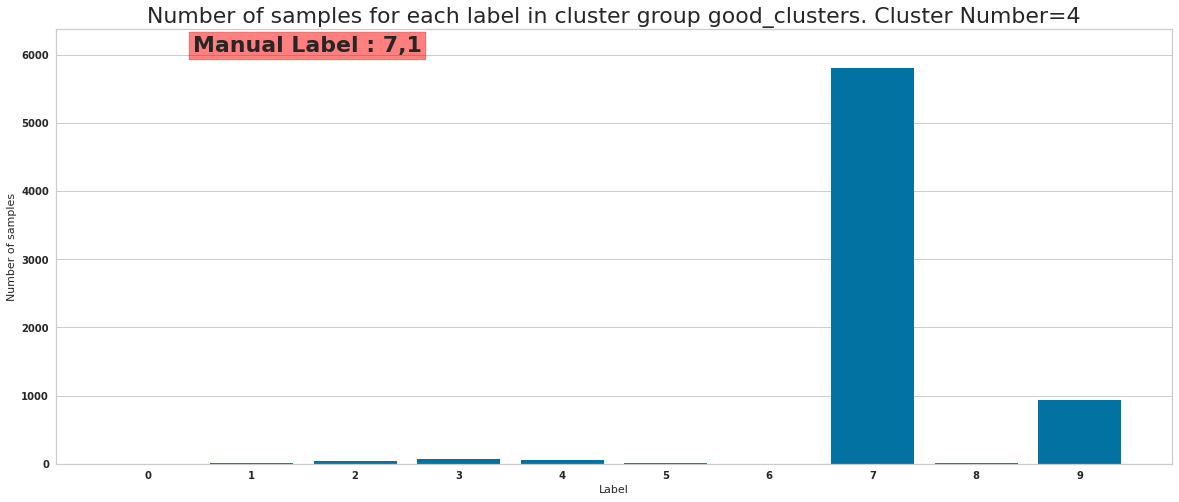

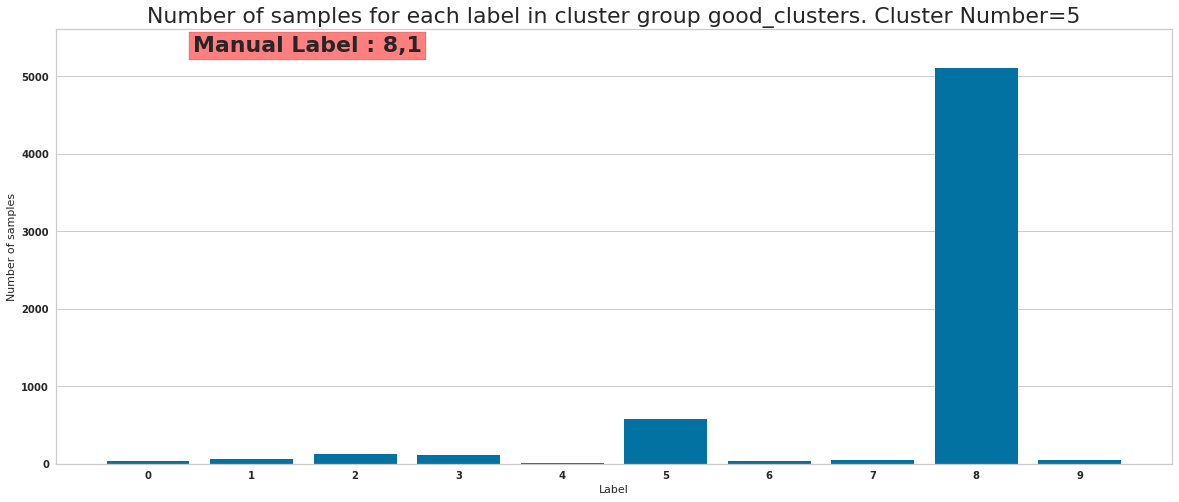

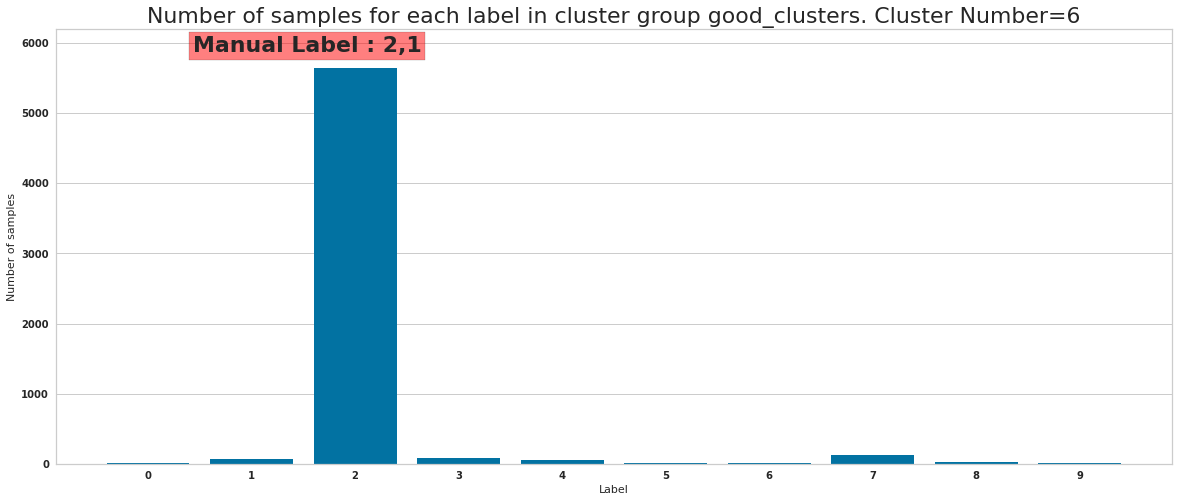

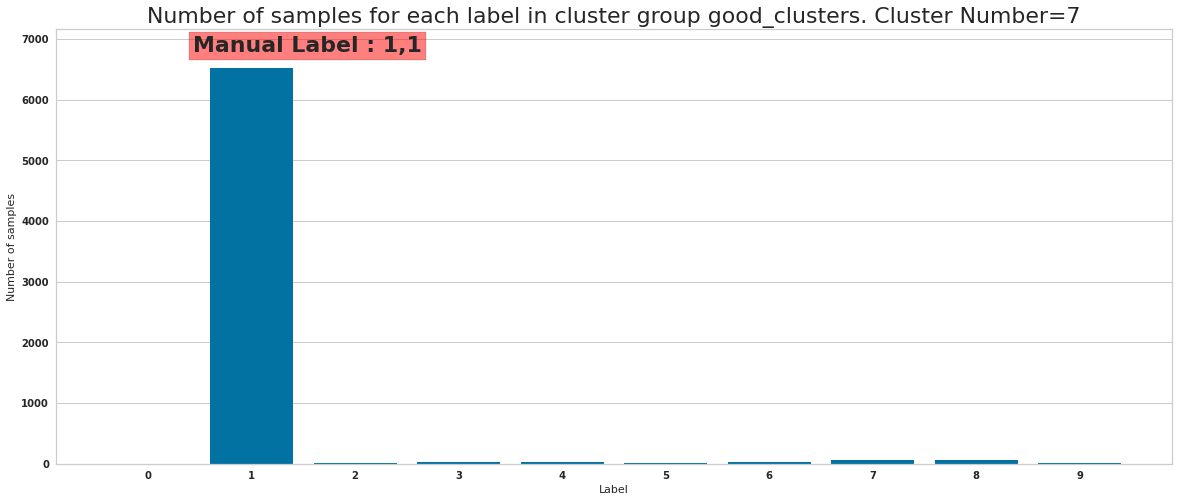

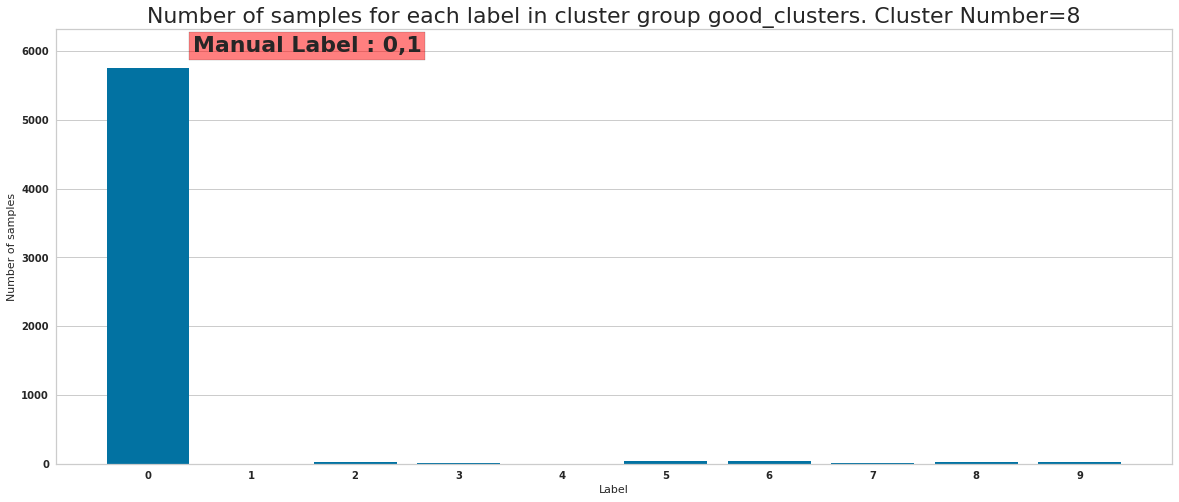

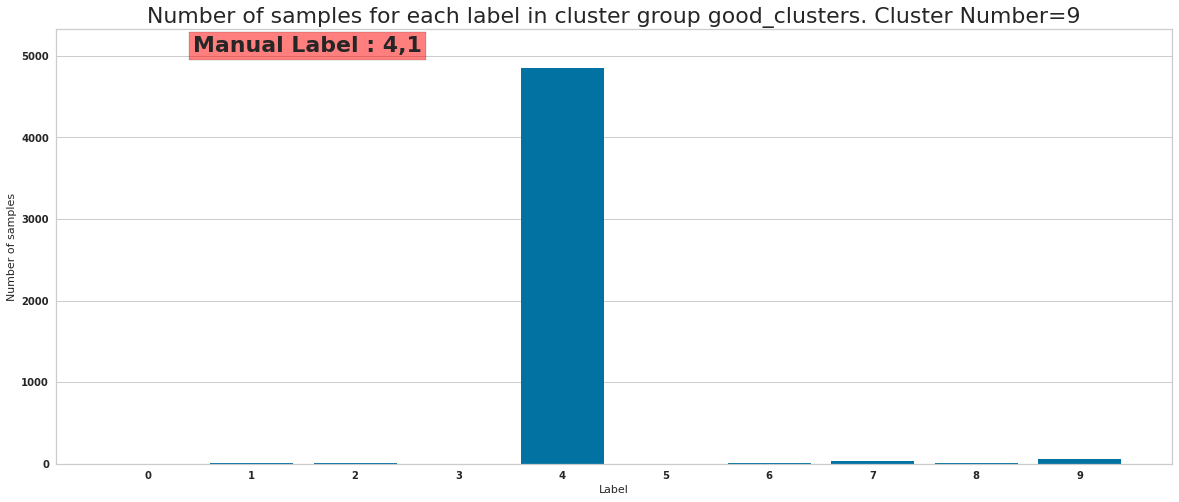

In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(5918, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(2646, 16)
(5789, 16)
(8614, 16)
(6948, 16)
(6169, 16)
(6033, 16)
(6766, 16)
(5909, 16)
(4984, 16)
Posterior probability shape (59776, 10)


In [ ]:
# level_2_cluster_dict = level2_manual_annotations[5]

# level_2_cluster_dict["manual_labels"] = [-1, -1, 3,3,
#                                          -1,-1,-1,3,
#                                          -1, 3
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0,0,1,1,
#                                              0,0,0,1,
#                                              0,1]


# level_2_cluster_dict = level2_manual_annotations[6]

# level_2_cluster_dict["manual_labels"] = [4, 9, 9,4,
#                                          4,4,-1,4,
#                                          4, 4
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.8,
#                                              0.8,0.8,0,0.8,
#                                              0.8,0.8]

# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)


In [ ]:
level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)
level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)

process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name
                              )

num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
Computing distances from second level cluster centers


TypeError: ignored

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)

In [ ]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file


KeyError: ignored

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

In [ ]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

In [ ]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])



In [ ]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
#metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs += 5
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        learning_rate=1e-4,
                                        batch_size=128,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units,
                                        strides=strides,
                                        num_dense_layers=num_dense_layers,
                                        fully_convolutional=fully_convolutional,
                                        num_concepts=num_concepts,
                                        num_individual_samples_annotated=num_individual_samples_annotated,
                                        num_samples_wrongly_annotated=num_samples_wrongly_annotated,
                                        total_confidence_of_wrong_annotation=total_confidence_of_wrong_annotation
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [256, 128, 128, 64], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 5, 'Z_DIM': 16, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 128, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'FULLY_CONVOLUTIONAL': True, 'NUM_CONCEPTS': 20, 'SUPERVISE_WEIG

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
0 (128, 14, 14, 256)
1 (128, 7, 7, 128)
2 (128, 4, 4, 128)
3 (128, 4, 4, 64)
z (128, 4, 4, 2)
z reshaped (128, 32)
Decoding
n units in fully_deconv [256, 128, 128, 64]
0 (128, 4, 4, 64)
1 (128, 4, 4, 128)
2 (128, 7, 7, 128)
3 (128, 14, 14, 256)
(128, 28, 28, 1)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_12

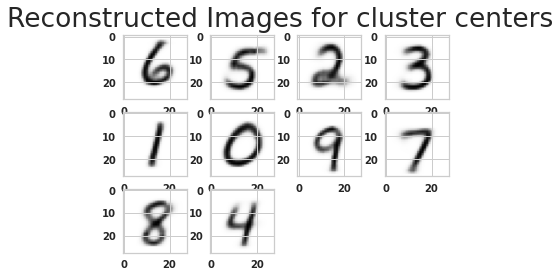

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                    )
display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")


In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 5, , 3,
                                           1, 0, 9, 7,
                                           8, 4
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

SyntaxError: ignored

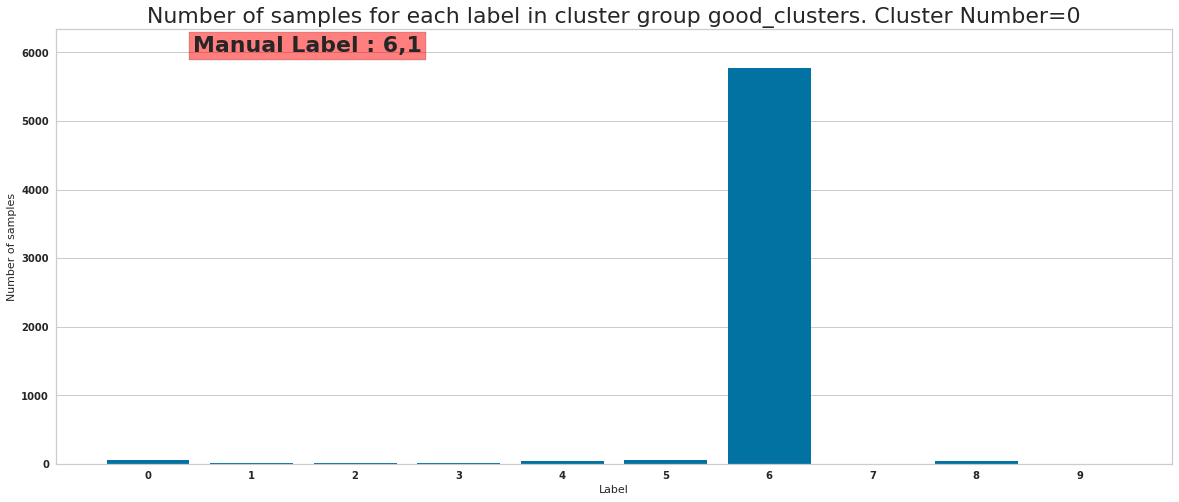

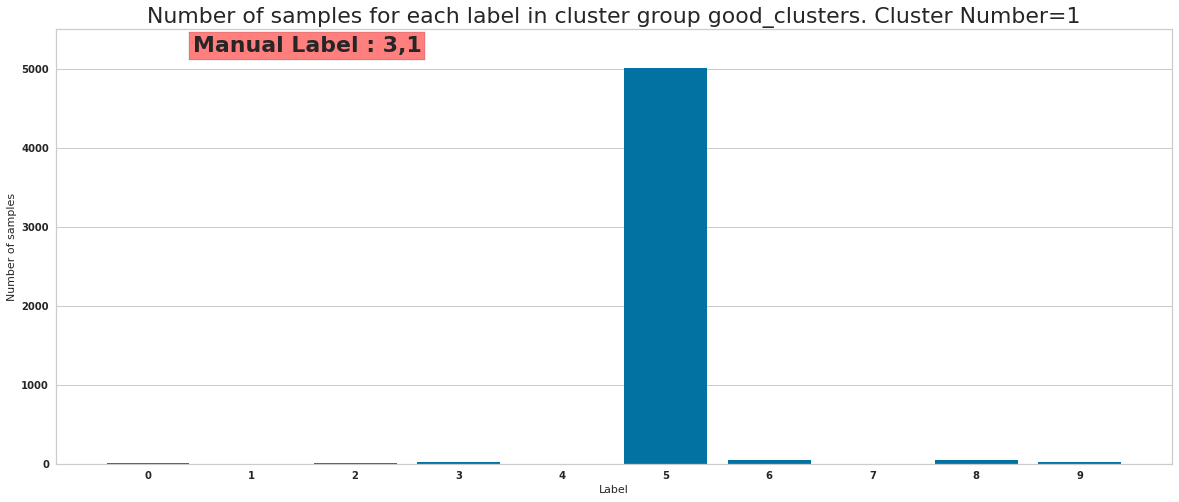

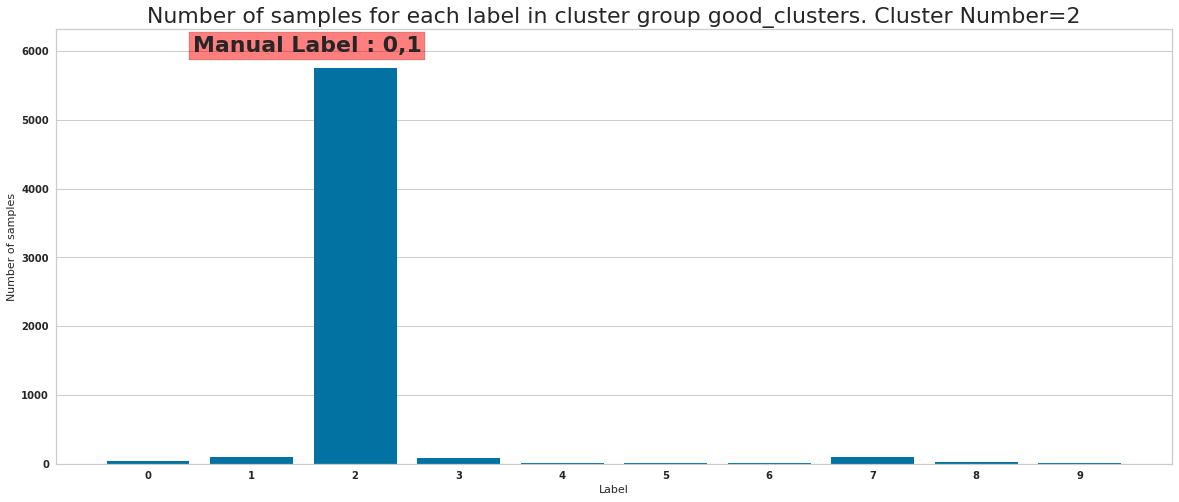

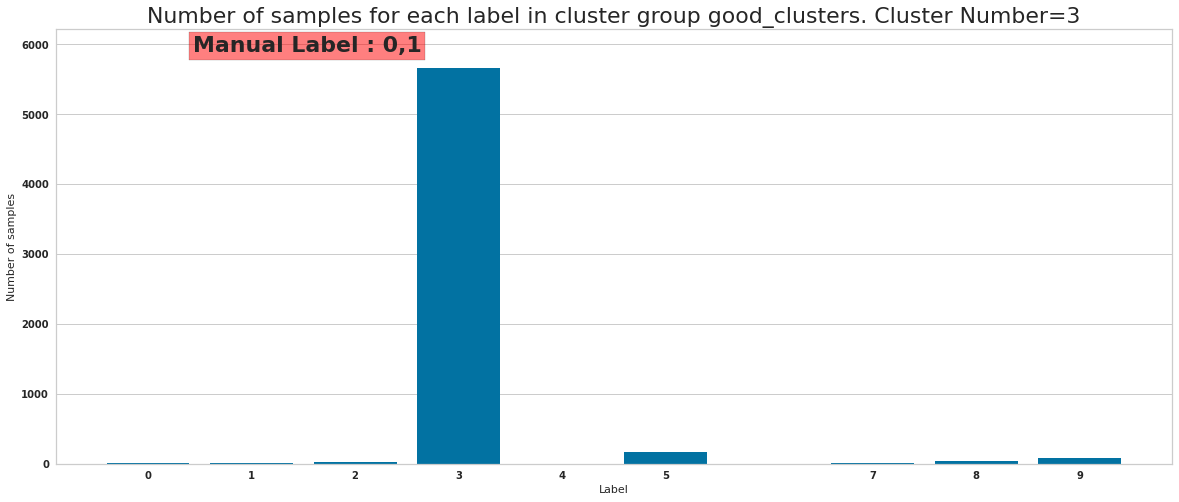

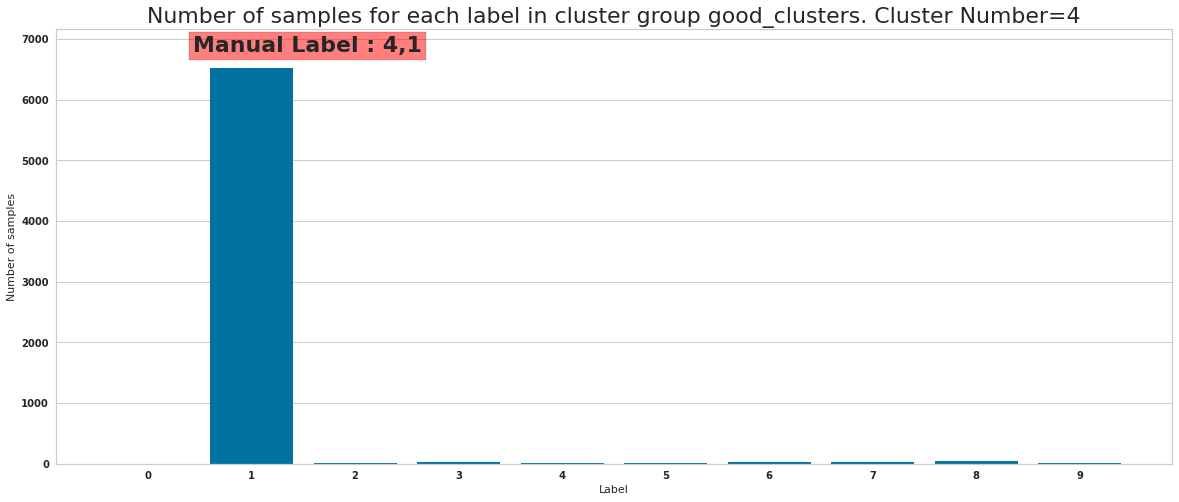

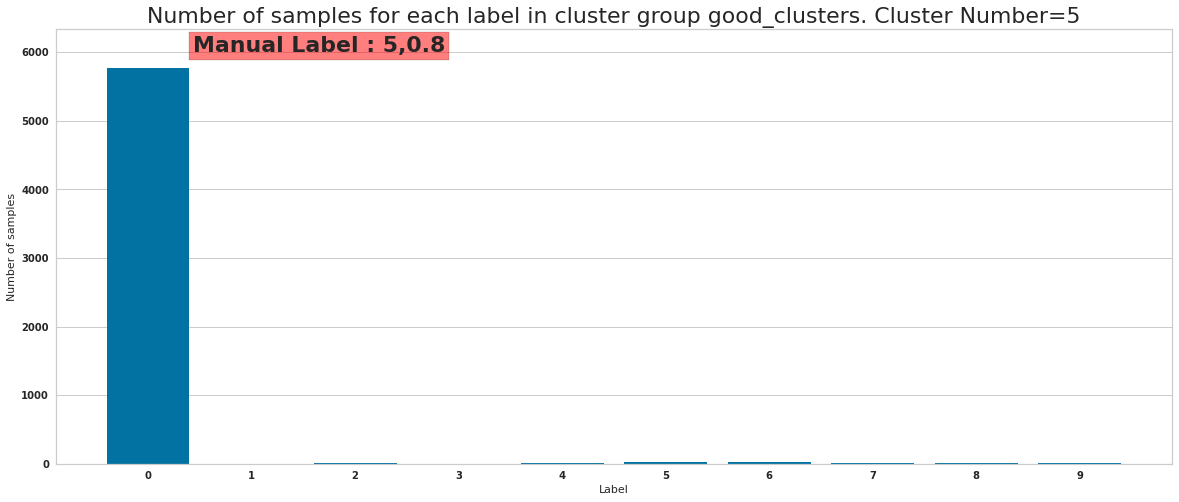

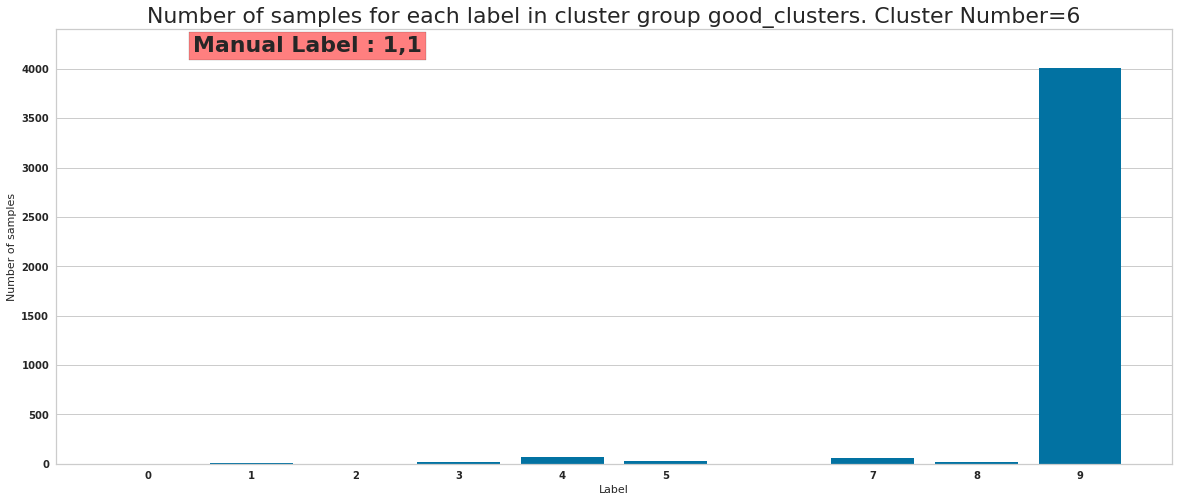

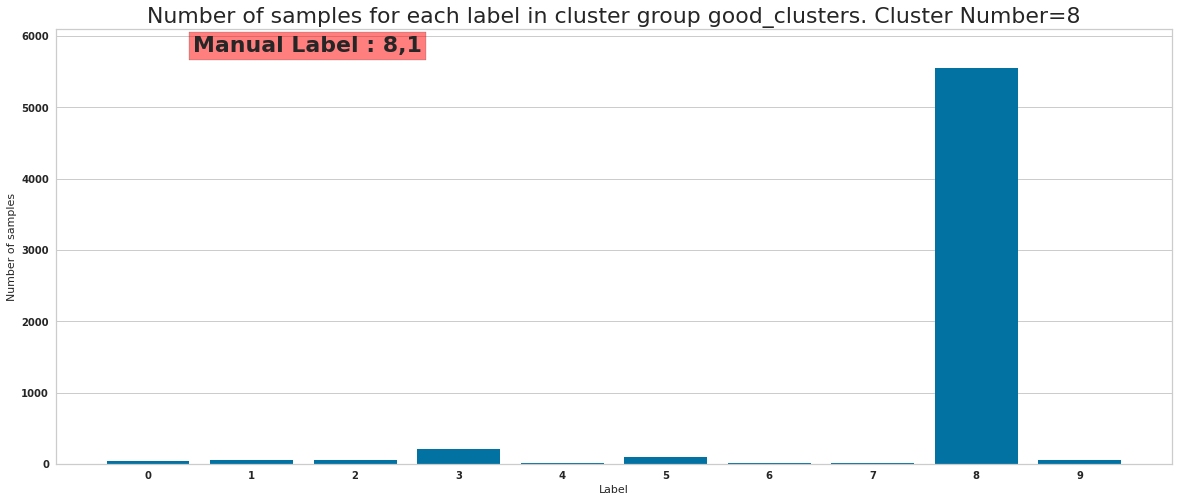

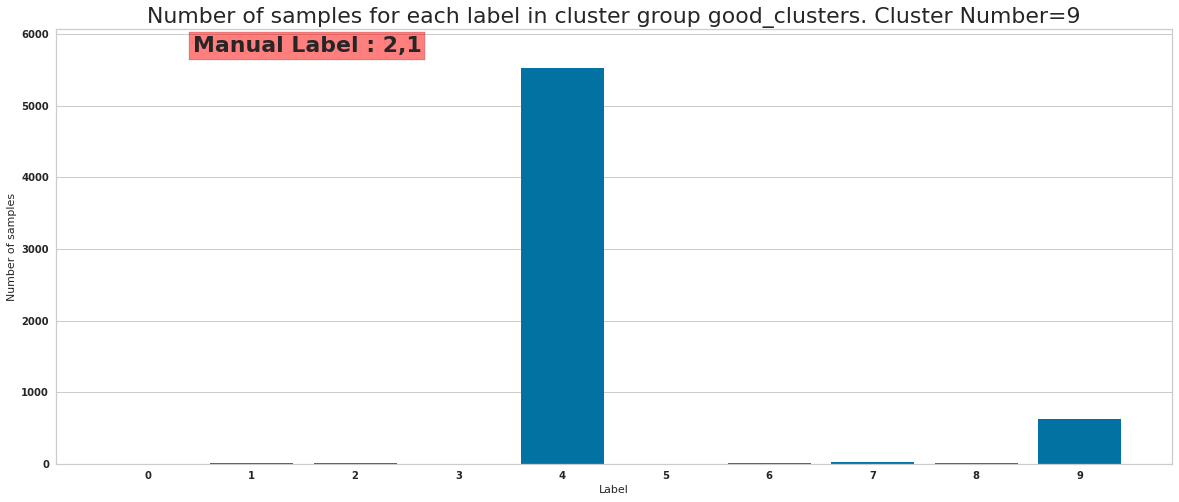

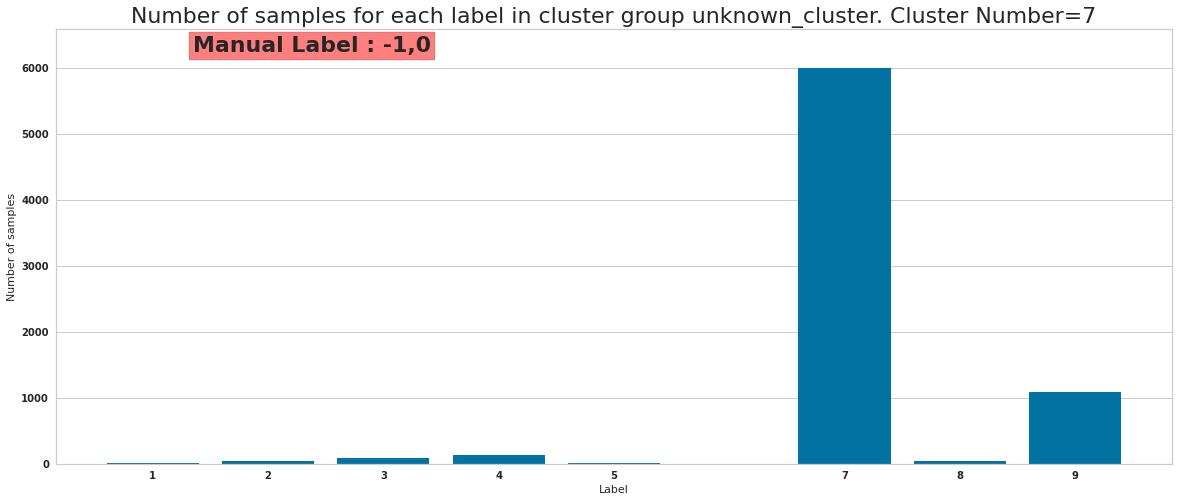

In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

(6001, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(5147, 16)
(6139, 16)
(6015, 16)
(6702, 16)
(5864, 16)
(4203, 16)
(7422, 16)
(6079, 16)
(6204, 16)
Posterior probability shape (59776, 10)
7 -1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
0 (128, 14, 14, 256)
1 (128, 7, 7, 128)
2 (128, 4, 4, 128)
3 (128, 4, 4, 64)
z (128, 4, 4, 2)
z reshaped (128, 32)
Decoding
n units in fully_deconv [256, 128, 128, 64]
0 (128, 4, 4, 64)
1 (128, 4, 4, 128)
2 (128, 7, 7, 128)
3 (128, 14, 14, 256)
(128, 28, 28, 1)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_41/analysis/cluster_centers__level_2_epoch_20.0_cluster_id_7.png


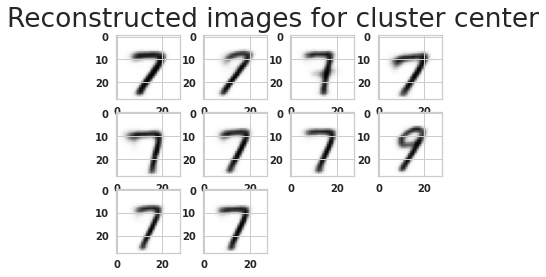

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [ ]:
# level_2_cluster_dict = level2_manual_annotations[7]

# level_2_cluster_dict["manual_labels"] = [-1,7,9,7,
#                                          9,9,7,7,
#                                          9, 9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0, 0.9, 0.9, 0.9,
#                                              0.9,0.9,0.8,0.8,
#                                              0.9,1
#                                               ]

# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)



In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
7


KeyError: ignored

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)
            
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

KeyError: ignored

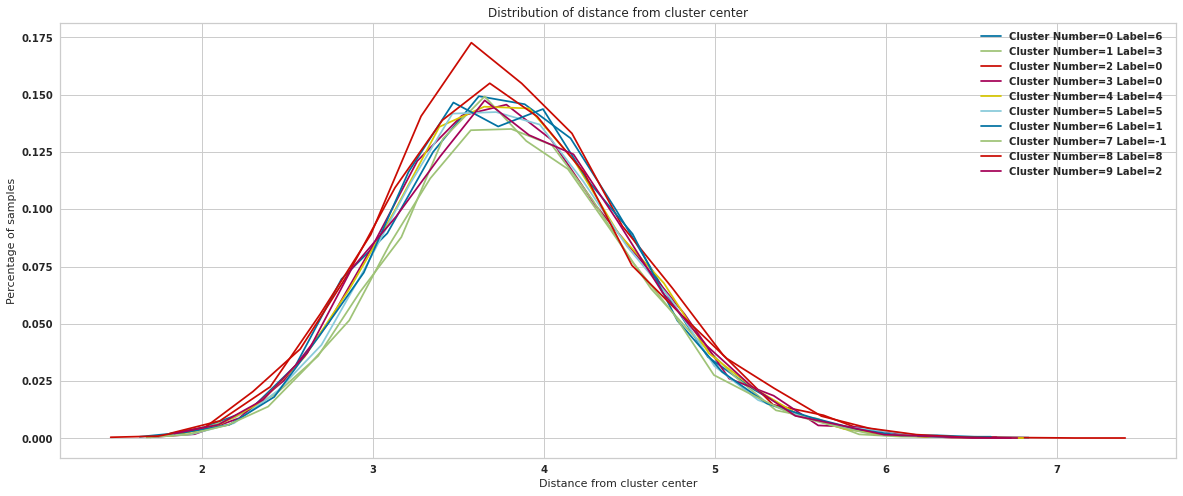

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
#metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        learning_rate=5e-4,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units,
                                        strides=strides,
                                        num_dense_layers=num_dense_layers,
                                        fully_convolutional=fully_convolutional,
                                        num_concepts=num_concepts
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [256, 128, 128, 64], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 5, 'Z_DIM': 16, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0005, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'FULLY_CONVOLUTIONAL': True, 'NUM_CONCEPTS': 20, 'SUPERVISE_WEIGH

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
0 (64, 14, 14, 256)
1 (64, 7, 7, 128)
2 (64, 4, 4, 128)
3 (64, 4, 4, 64)
z (64, 4, 4, 2)
z reshaped (64, 32)
Decoding
n units in fully_deconv [256, 128, 128, 64]
0 (64, 4, 4, 64)
1 (64, 4, 4, 128)
2 (64, 7, 7, 128)
3 (64, 14, 14, 256)
(64, 28, 28, 1)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_EL

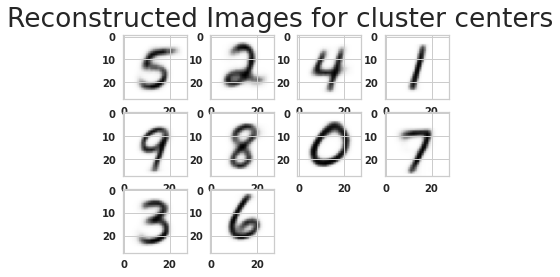

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                    )
display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")

In [ ]:
metric_df.head()

epoch  ...  total_confidence_of_wrong_annotation
0   12.0  ...                           1974.591464
1   13.0  ...                           1974.591464
2   14.0  ...                           1974.591464
3   15.0  ...                           1974.591464
4   16.0  ...                           1974.591464

[5 rows x 13 columns]

Getting manual_annotation


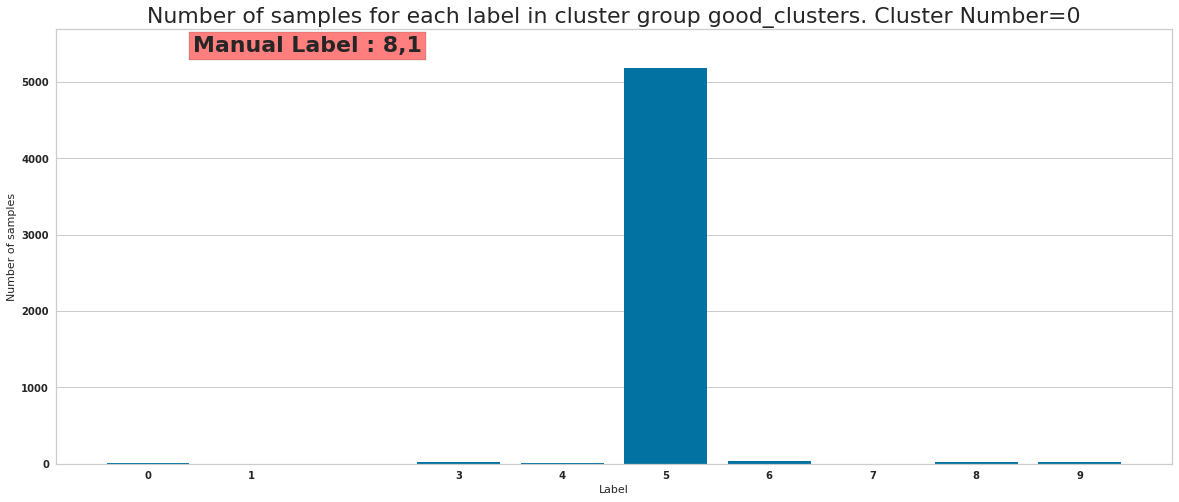

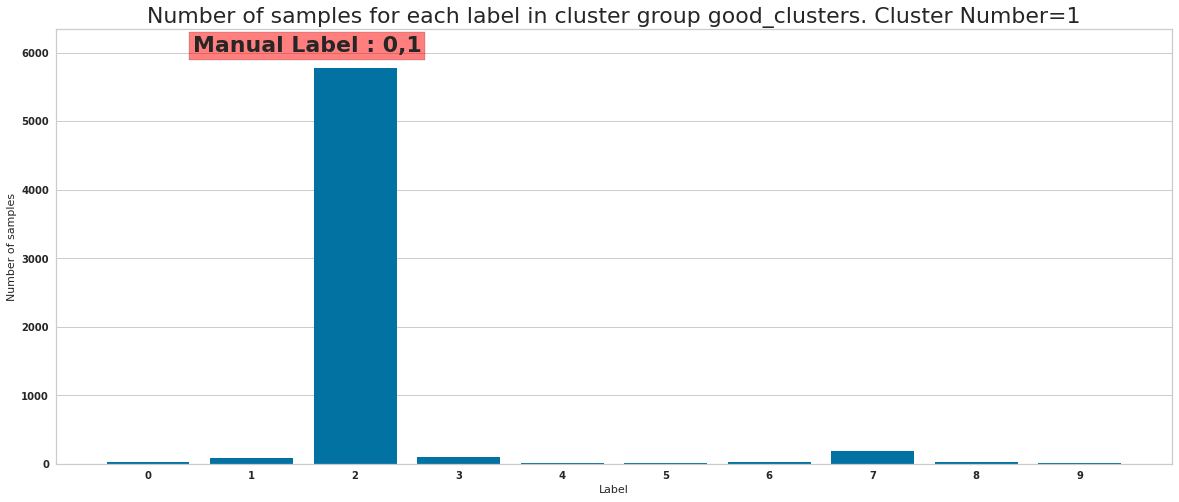

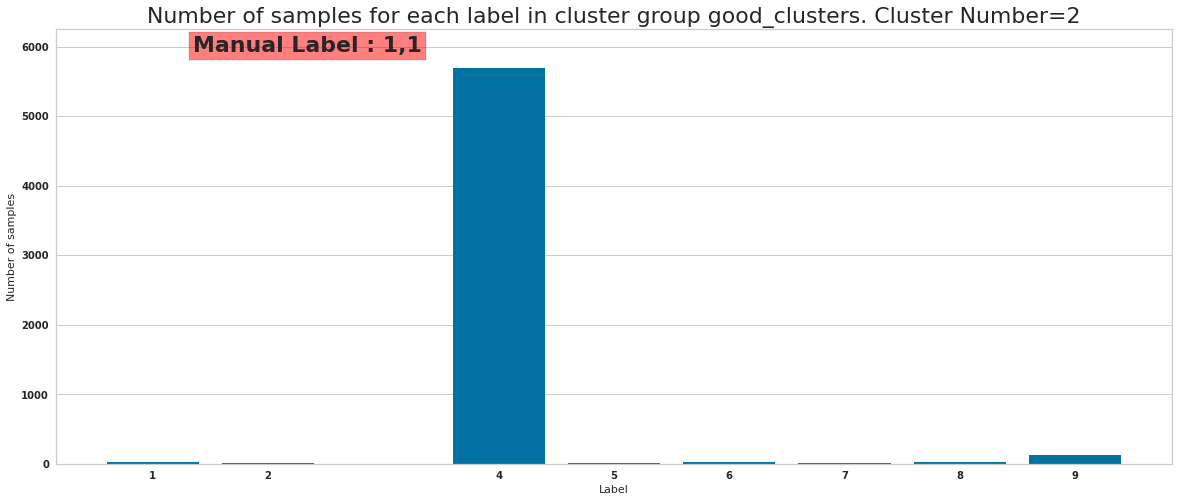

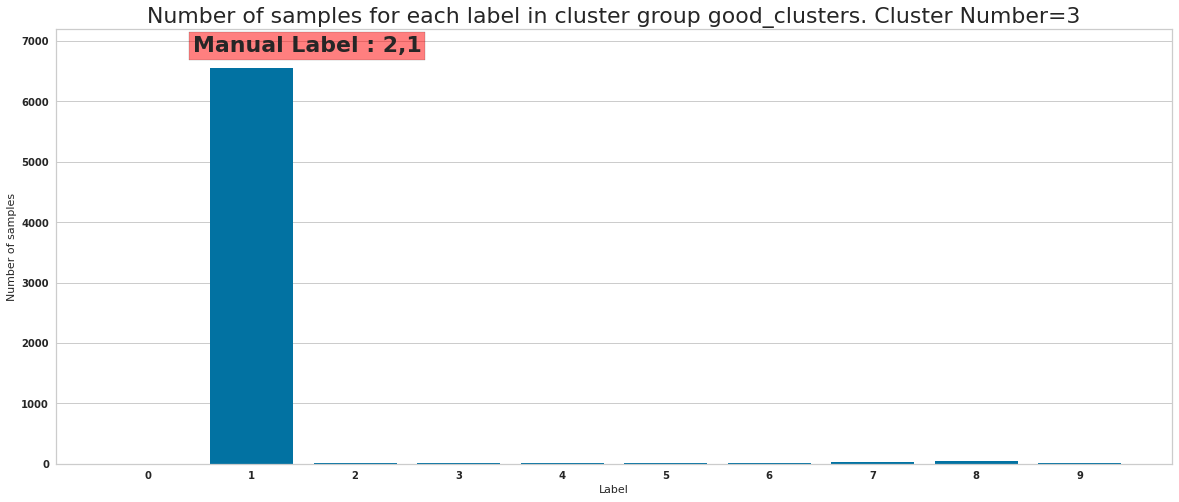

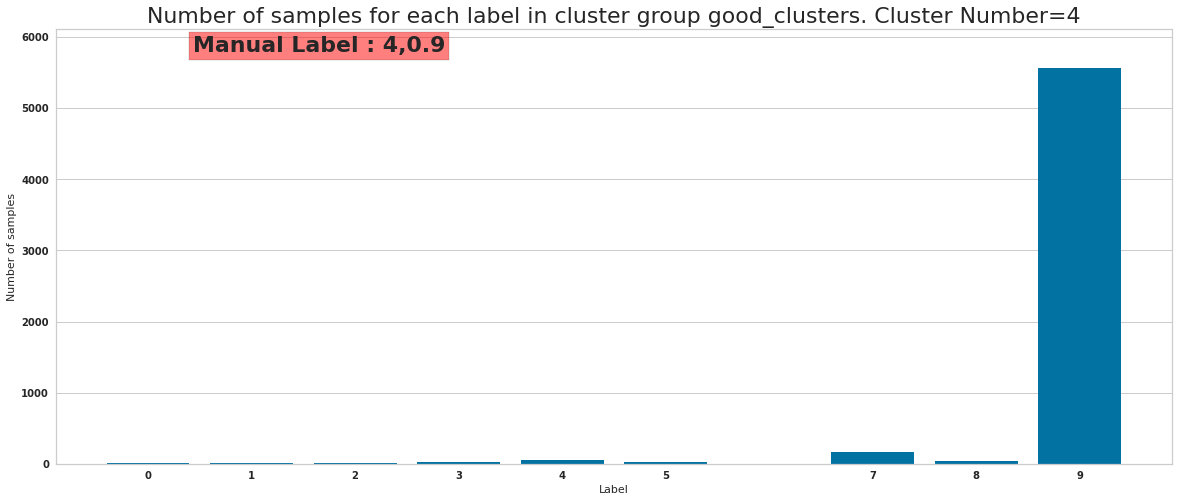

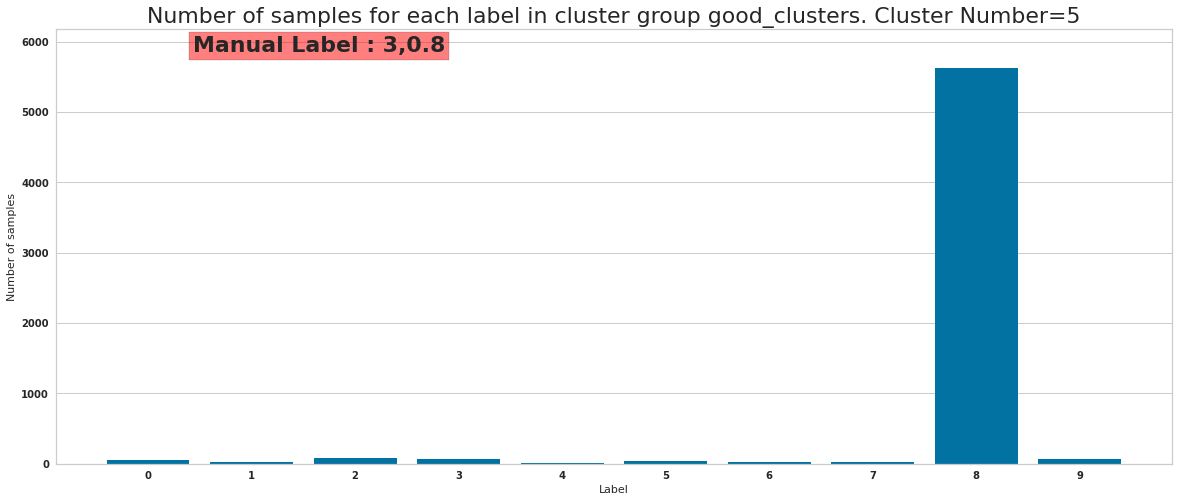

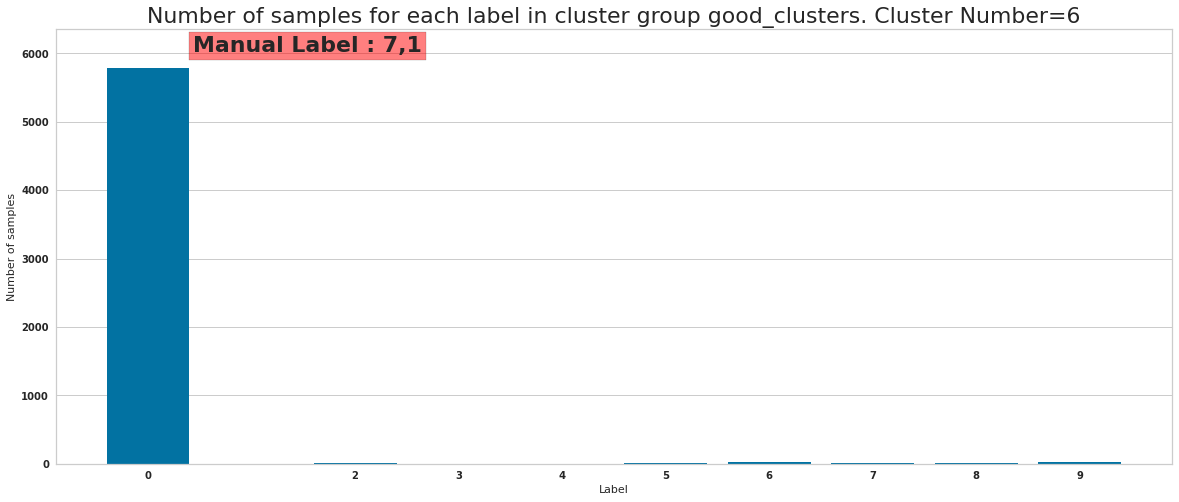

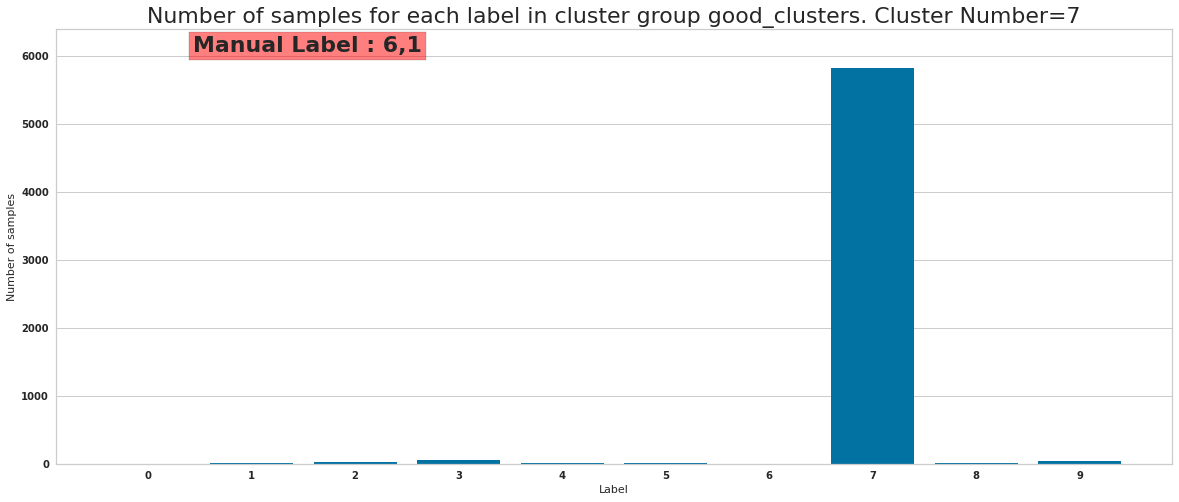

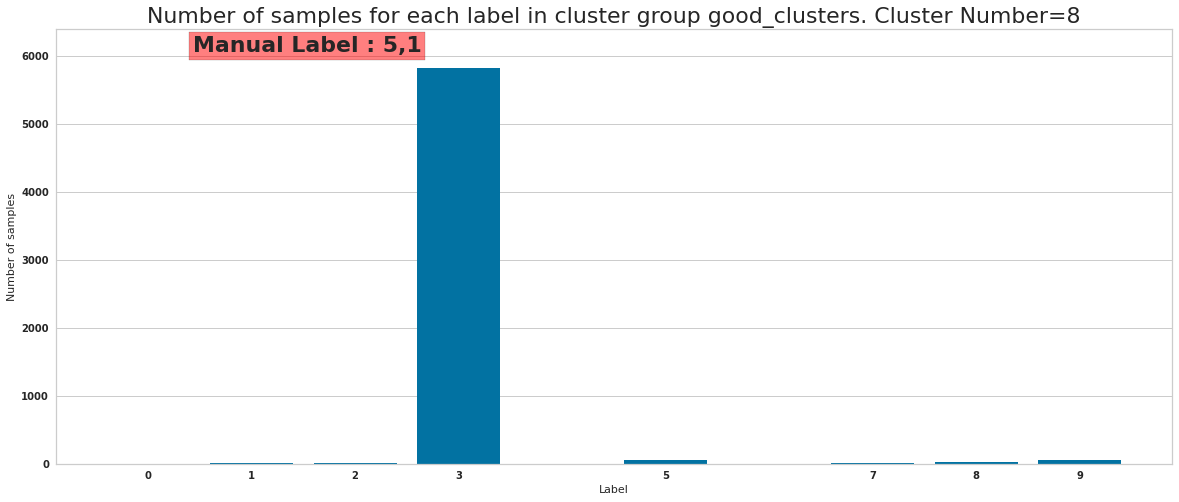

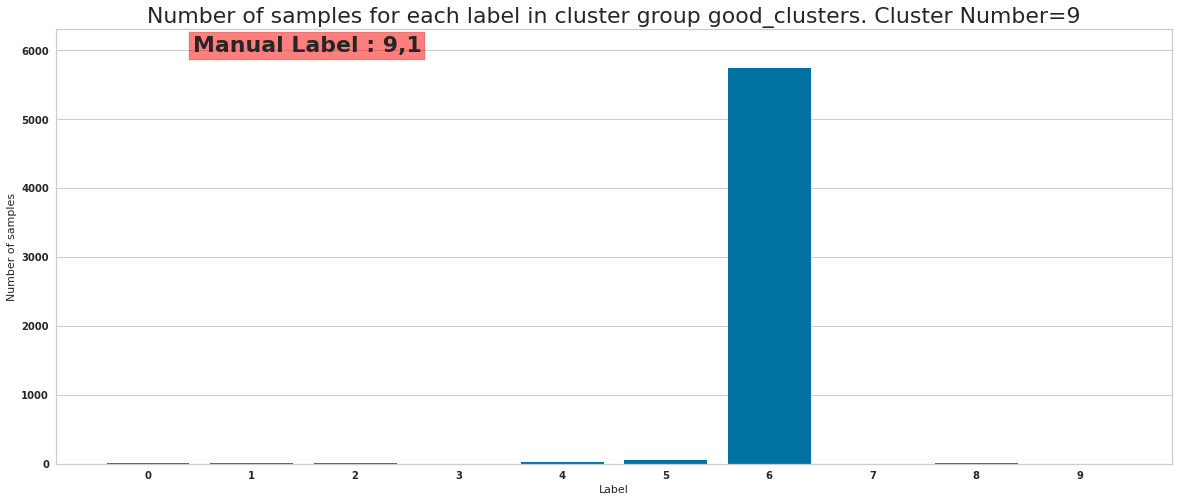

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [8,0,1,2,
                                          4,3,7,6,
                                           5,9
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               0.9, 0.8, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(5310, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(6277, 16)
(5928, 16)
(6687, 16)
(5897, 16)
(6019, 16)
(5886, 16)
(5969, 16)
(5998, 16)
(5869, 16)
Posterior probability shape (59840, 10)


In [ ]:
# level_2_cluster_dict = level2_manual_annotations[3]

# level_2_cluster_dict["manual_labels"] = [3,8,3,-1,
#                                          8,8,3,8,
#                                          8, 3
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.9, 0.9, 0.9, 0,
#                                              0.9,0.9,0.9,0.9,
#                                              0.9,0.9
#                                               ]

# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)



## Process second level clusters

In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
Computing distances from second level cluster centers
Manual Label 8
(5557, 57) (5557, 33)
Num correct=5037
Cluster 0 Manual Label 8 Percentage correct 90.64243296742846
********************************
Manual Label 0
(5862, 57) (5862, 33)
Num correct=5737
Cluster 1 Manual Label 0 Percentage correct 97.8676219720232
********************************
Manual Label 1
(6706, 57) (6706, 33)
Num correct=6506
Cluster 2 Manual Label 1 Percentage correct 97.0175961825231
********************************
Manual Label 2
(5977, 57) (5977, 33)
Num correct=5611
Cluster 3 Manual Label 2 Percentage correct 93.87652668562824
********************************
Manual Label 4
(5770, 57) (5770, 33)
Num correct=5431
Cluster 4 Manual Label 4 Percentage correct 94.12478336221837
********************************
Manual Label 3
(8167, 57) (8167, 33)
Num correct=5749
Cluster 5 Manual Label 3 Percentage correct 70.39304518182931
************************

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

## Save dataframes and plot graphs

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)        

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)


Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6
manual_label_7
manual_label_8
manual_label_9
manual_label_10
manual_label_11
manual_label_12
manual_label_13
manual_label_14


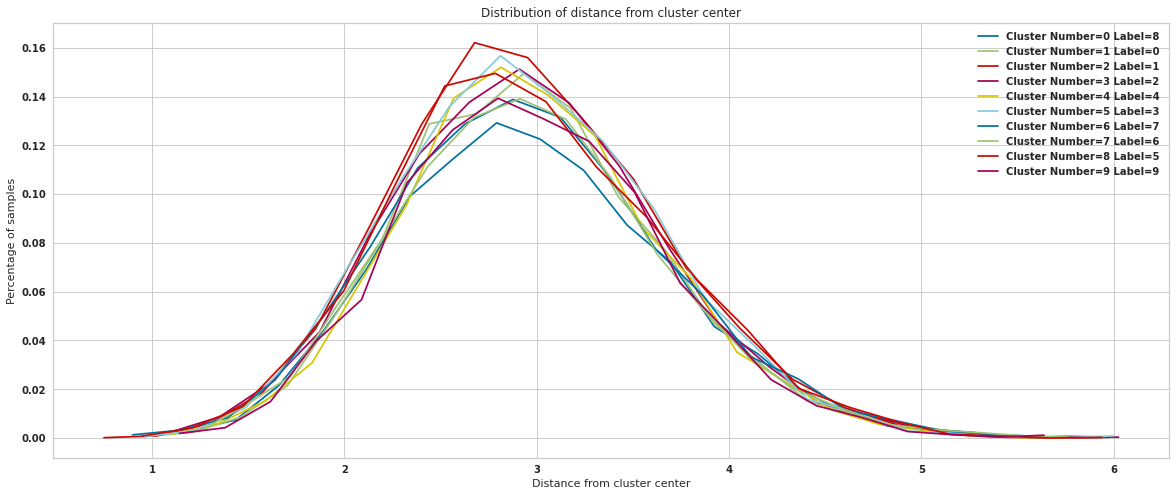

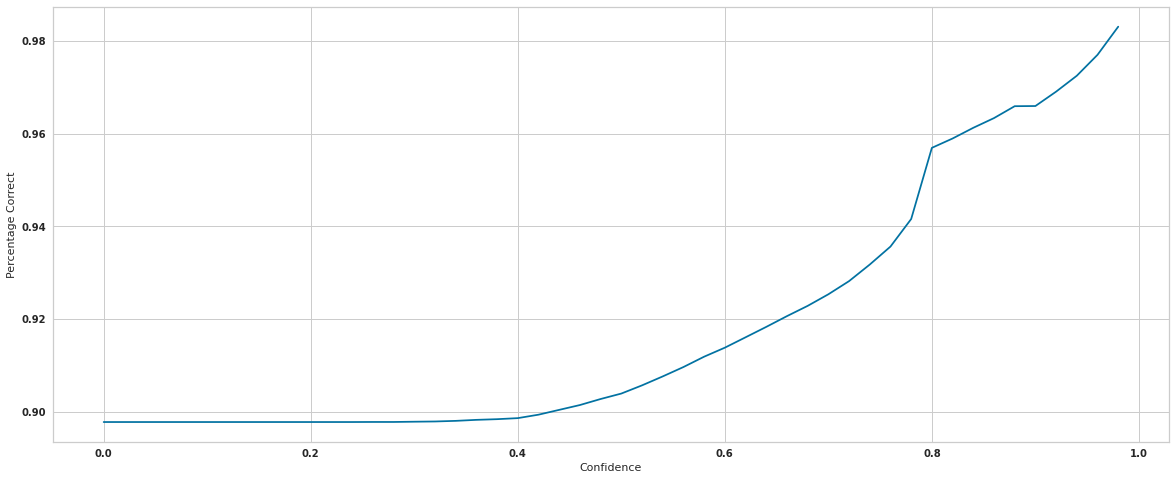

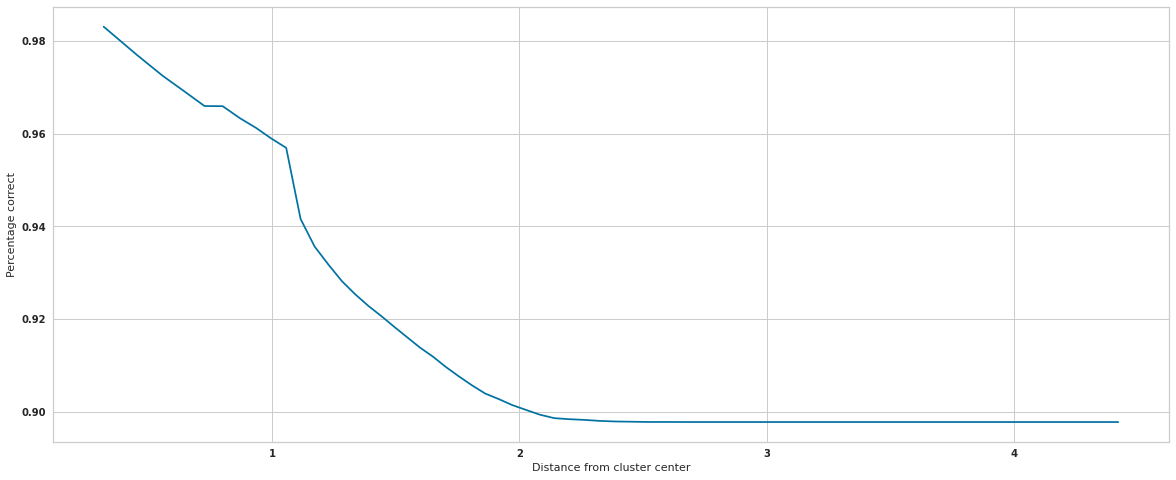

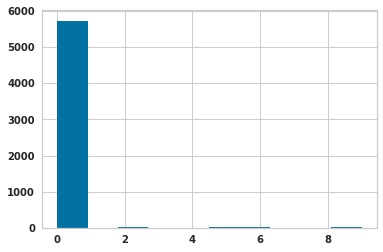

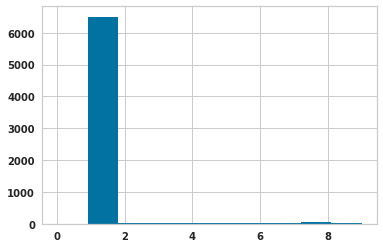

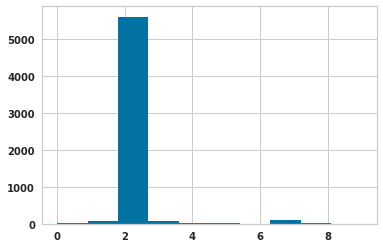

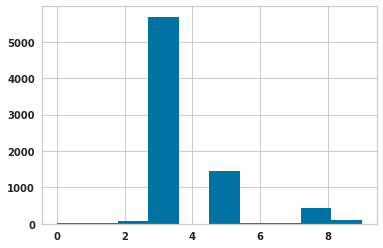

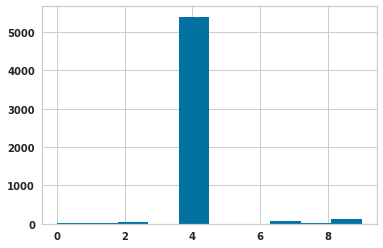

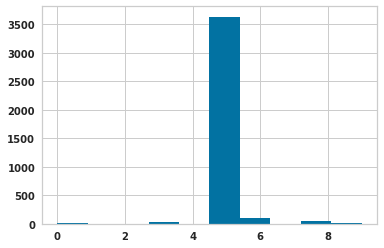

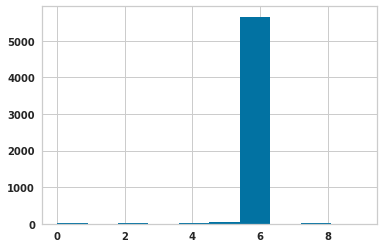

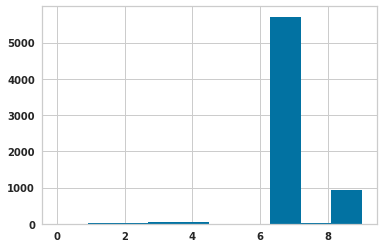

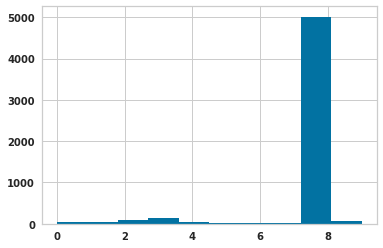

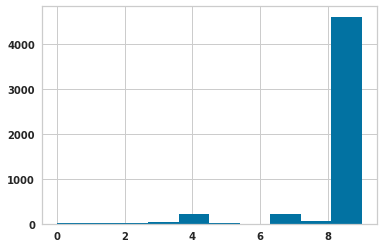

In [ ]:
# plot distribution for separate cluster groups- Percentage of samples present within a radius of x unit from cluster center
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)


num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

# Itertion 6

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        root_path=root_path,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units)
tf.reset_default_graph()

{'NUM_UNITS': [16, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 3, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'RUN_ID': 1, 'ID': 1, 'name': 'experiment_16_32'}
Loaded manual annotation
Nu

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/SemiSupervisedClassifierMnist.model-14025"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/SemiSupervisedClassifierMnist.model-14025"
 
ckpt_name SemiSupervisedClassifierMnist.model-14025
INFO:tensorflow:R

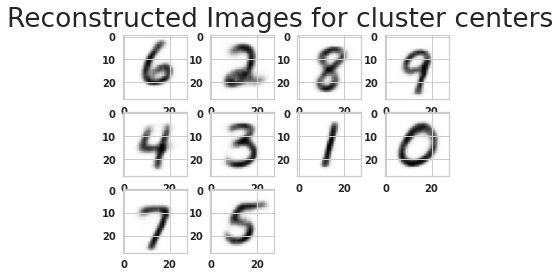

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                    )
display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")

Getting manual_annotation


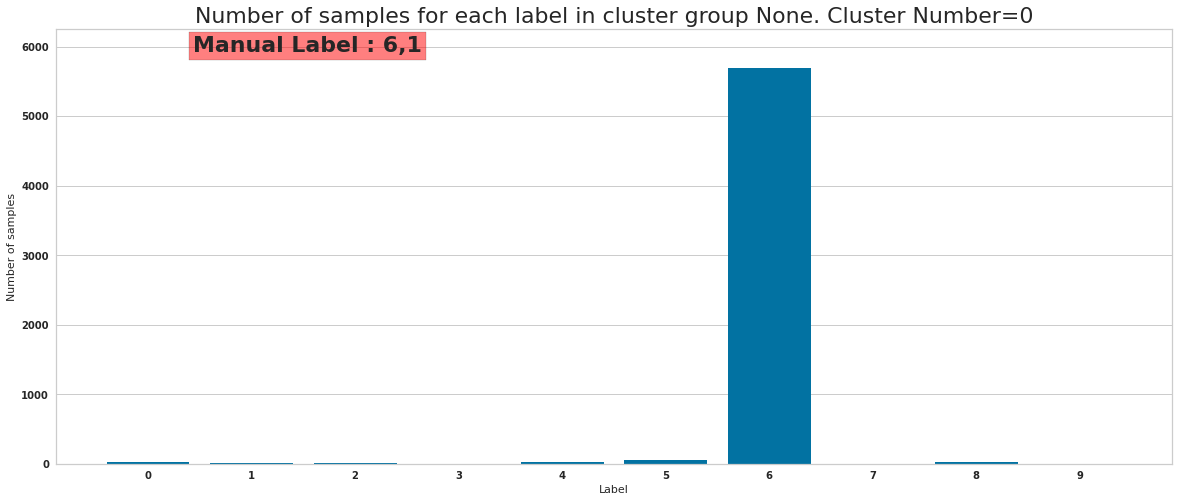

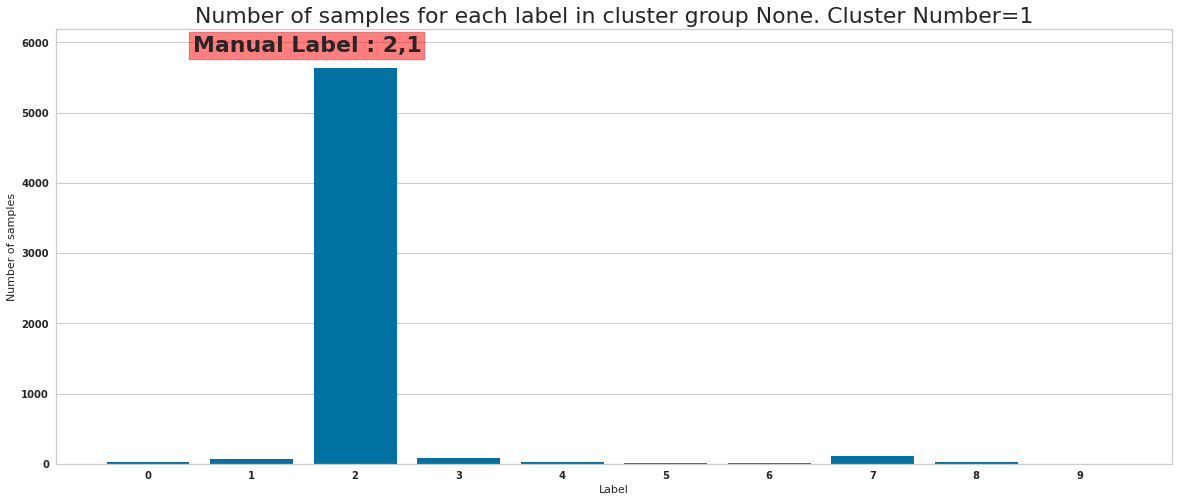

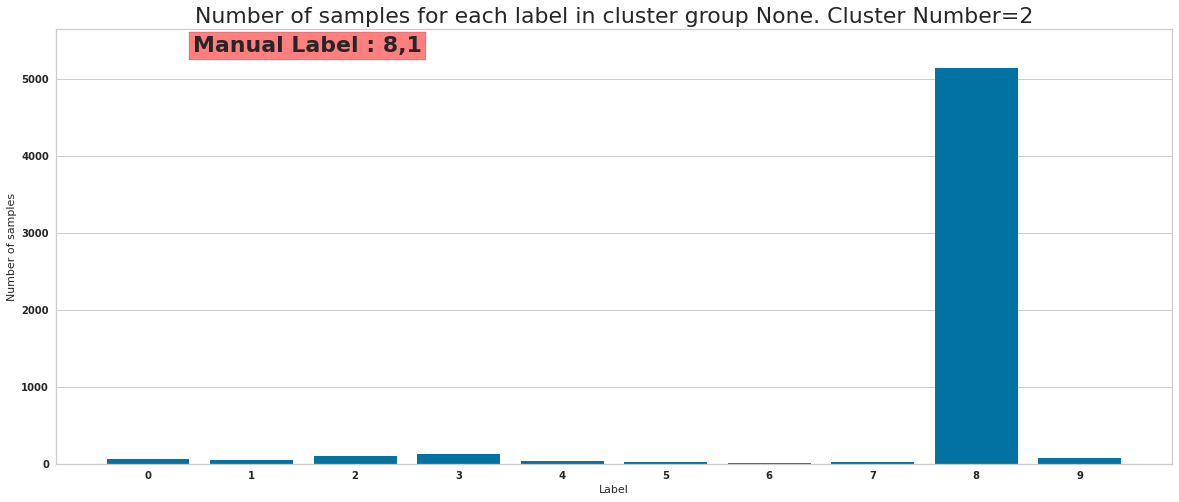

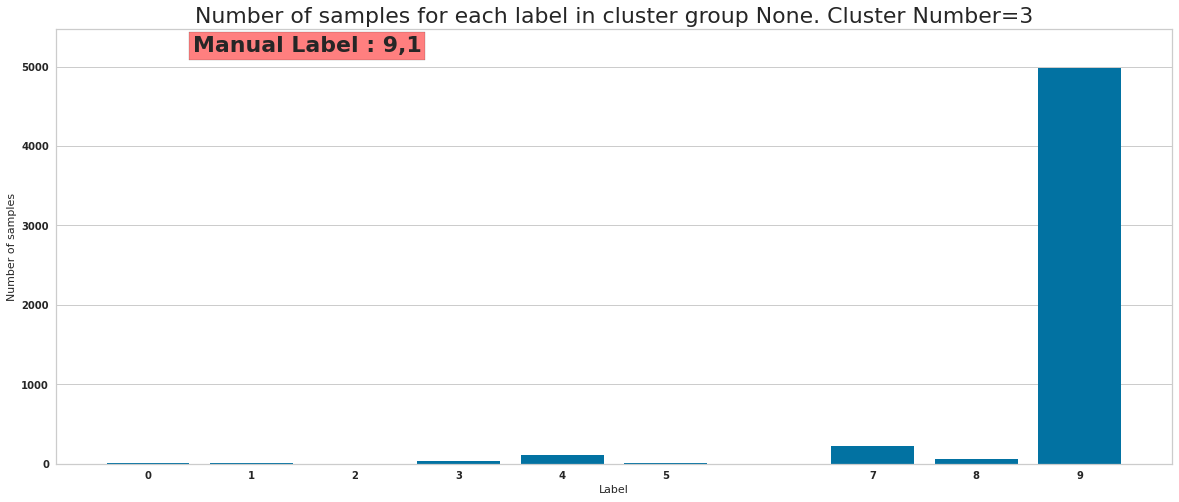

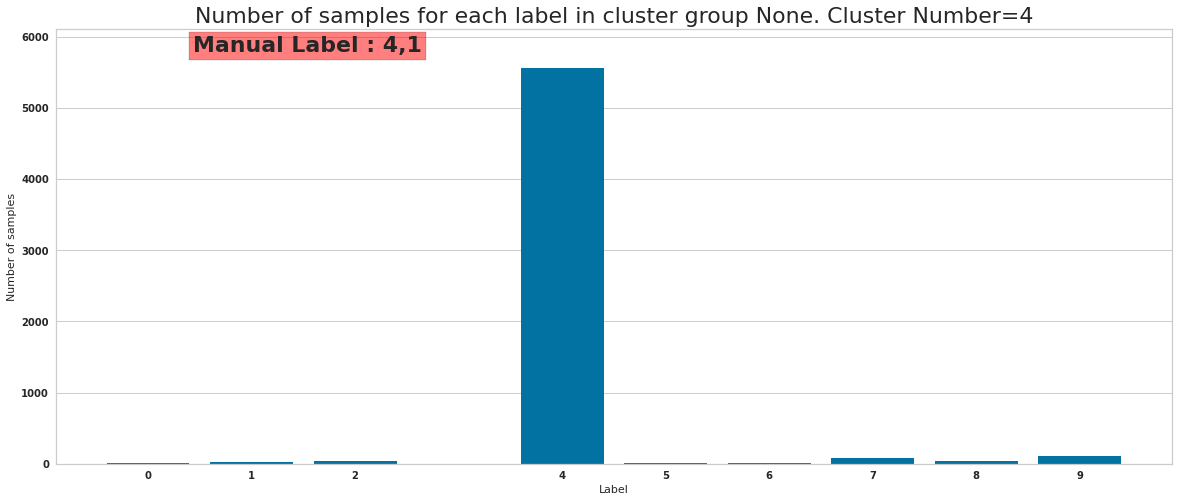

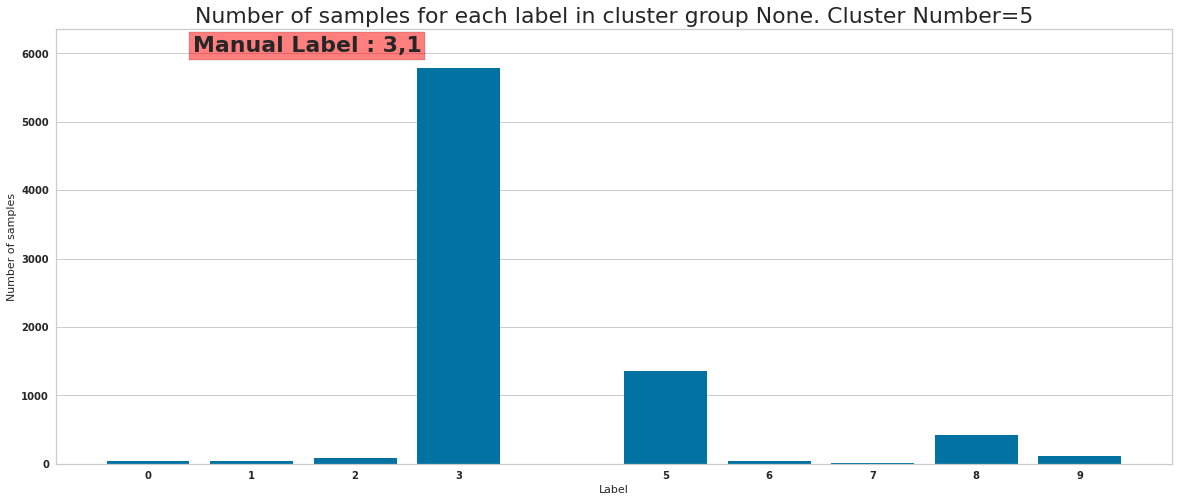

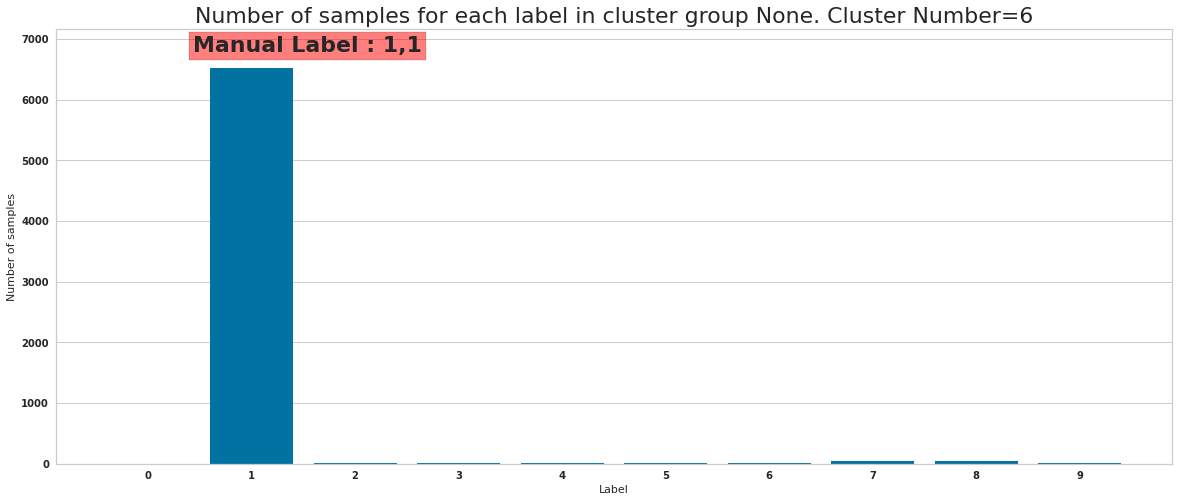

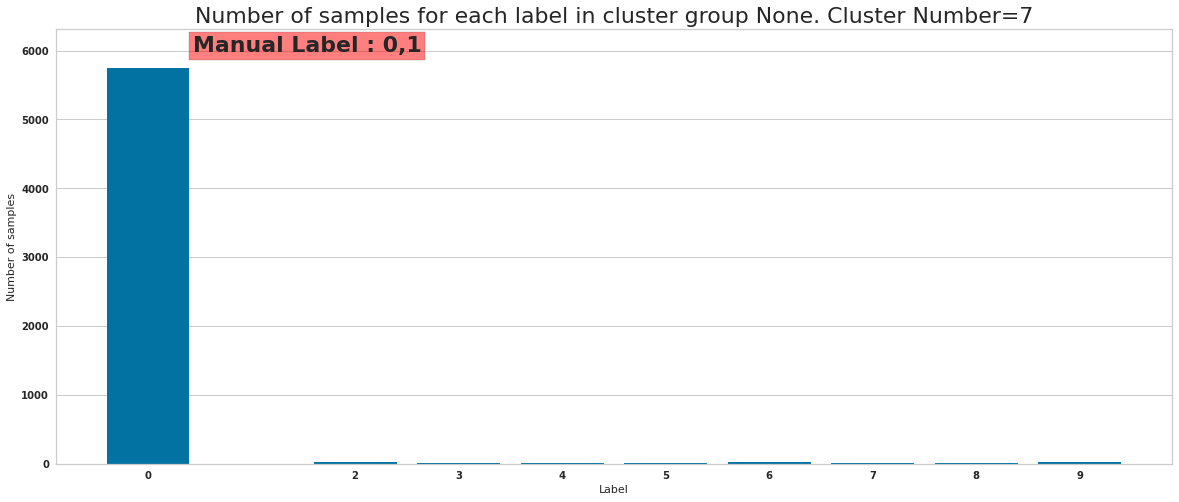

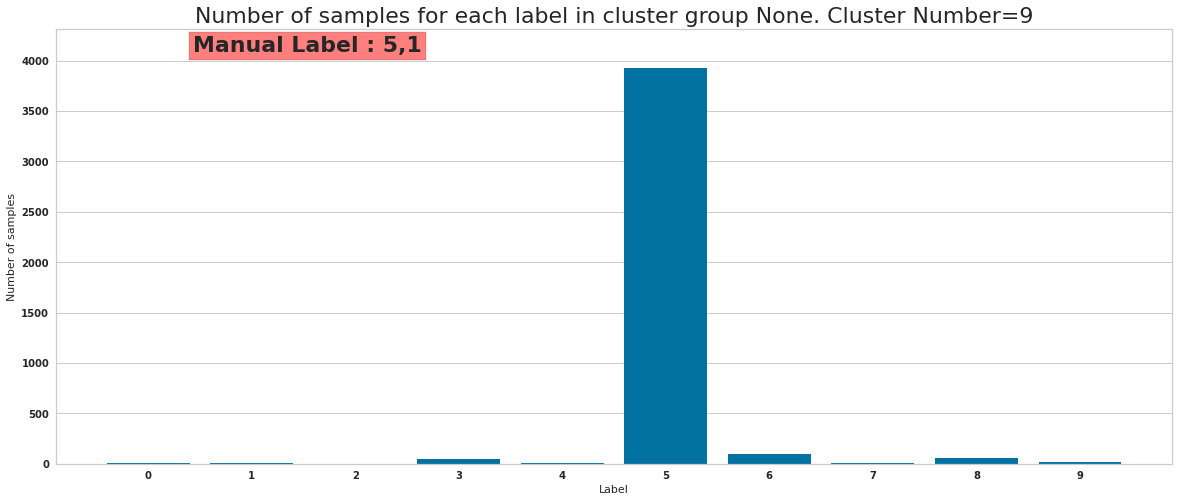

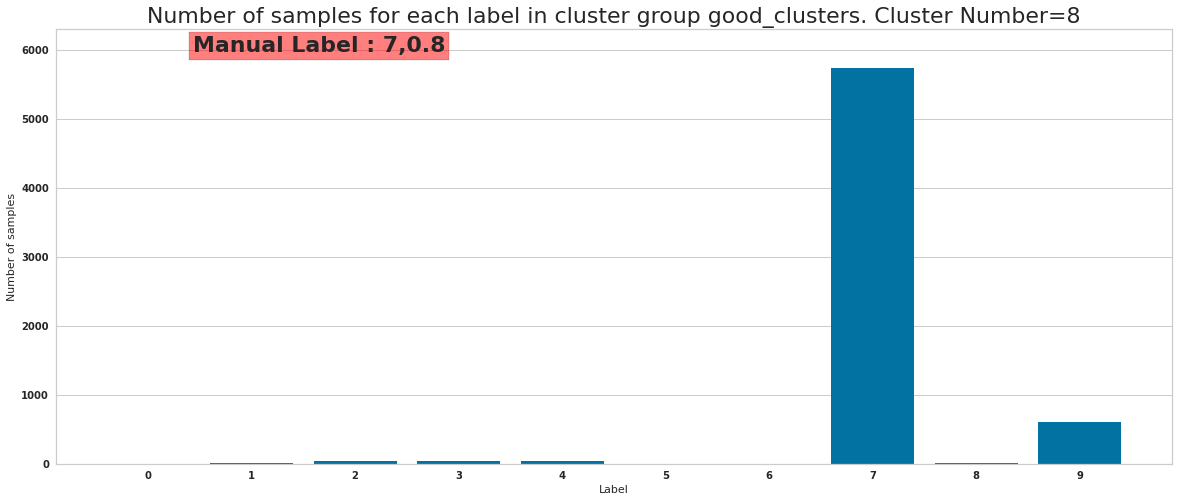

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6,2,8,9,
                                           4,3,1,0,
                                           7,5
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               0.8, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(5837, 10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(5982, 10)
(5637, 10)
(5444, 10)
(5883, 10)
(7884, 10)
(6678, 10)
(5863, 10)
(6463, 10)
(4169, 10)
Posterior probability shape (59840, 10)


In [ ]:
# level_2_cluster_dict = level2_manual_annotations[2]

# level_2_cluster_dict["manual_labels"] = [2, 1, -1, 1,
#                                          1, 2, 1, 1,
#                                          2, 1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.8, 0.9, 0, 1,
#                                              1, 0.9, 1, 1,
#                                              0.9, 1
#                                               ]

# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)



## Process second level clusters

In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
Computing distances from second level cluster centers
Manual Label 6
(5837, 57) (5837, 33)
Num correct=5687
Cluster 0 Manual Label 6 Percentage correct 97.43018673976357
********************************
Manual Label 2
(5982, 57) (5982, 33)
Num correct=5628
Cluster 1 Manual Label 2 Percentage correct 94.08224674022067
********************************
Manual Label 8
(5637, 57) (5637, 33)
Num correct=5137
Cluster 2 Manual Label 8 Percentage correct 91.13003370587192
********************************
Manual Label 9
(5444, 57) (5444, 33)
Num correct=4977
Cluster 3 Manual Label 9 Percentage correct 91.42174871418075
********************************
Manual Label 4
(5883, 57) (5883, 33)
Num correct=5554
Cluster 4 Manual Label 4 Percentage correct 94.40761516233215
********************************
Manual Label 3
(7884, 57) (7884, 33)
Num correct=5778
Cluster 5 Manual Label 3 Percentage correct 73.28767123287672
**********************

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

## Save dataframe and plot graphs

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "z")
df.to_csv(exp_config.ANALYSIS_PATH + filename, index=False)
cluster_center_filename = get_encoded_csv_file(exp_config, int(epochs_completed), "train", "cluster_center")
with open(exp_config.ANALYSIS_PATH + cluster_center_filename,"w") as json_file:
    json.dump(cluster_centers.tolist(), json_file)        

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)


Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6
manual_label_7
manual_label_8
manual_label_9
manual_label_10
manual_label_11
manual_label_12
manual_label_13
manual_label_14
manual_label_15


## Plot distance distribution

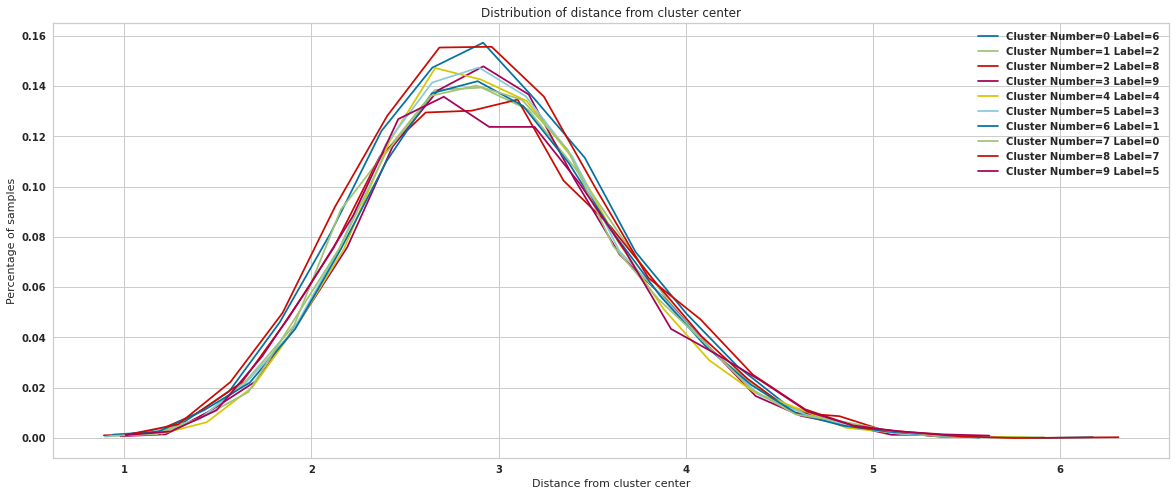

In [ ]:
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

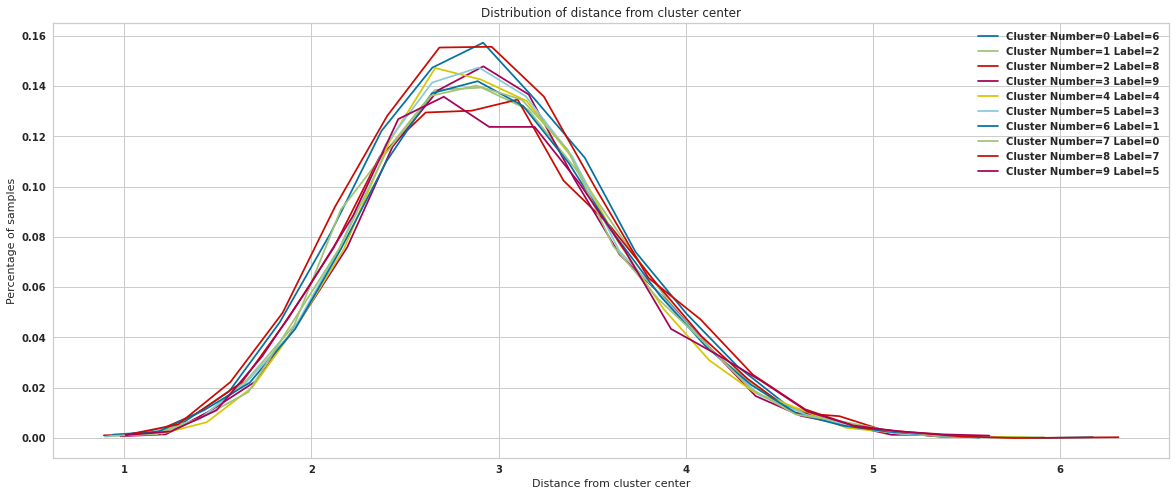

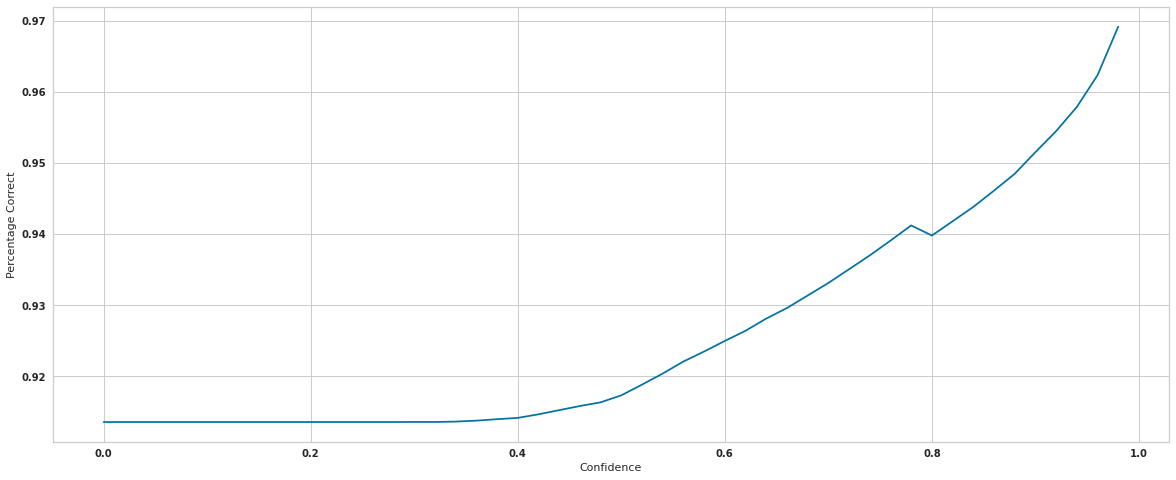

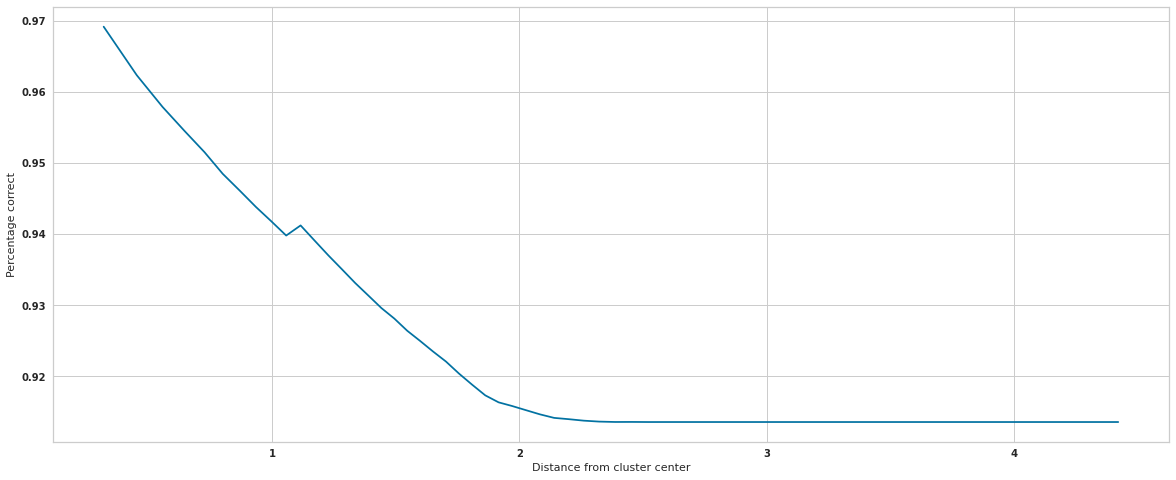

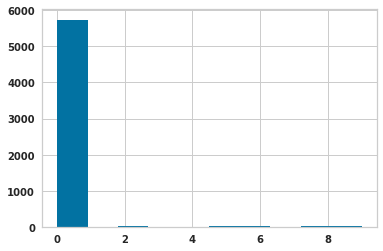

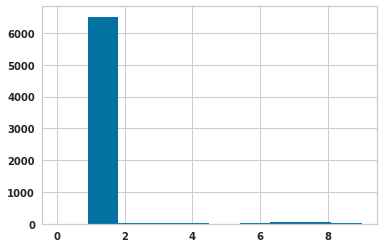

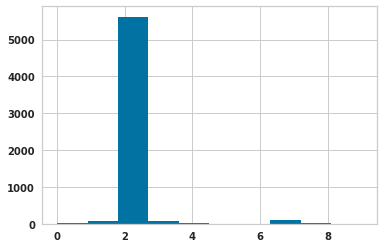

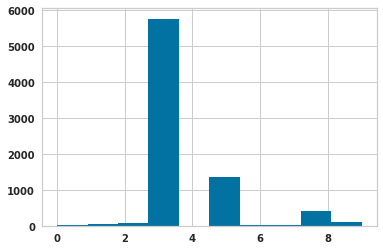

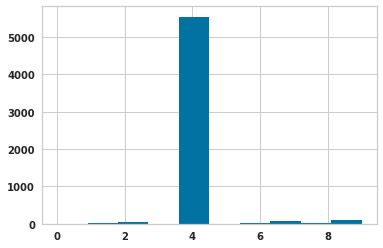

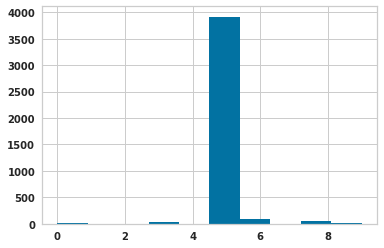

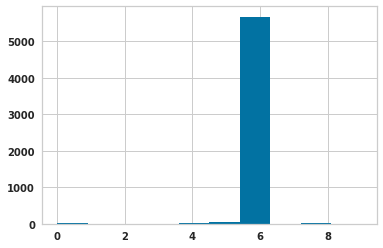

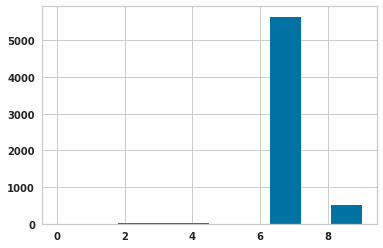

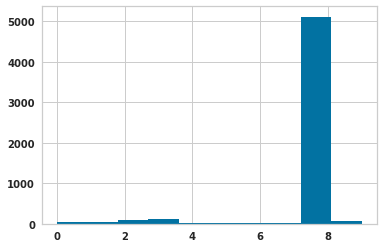

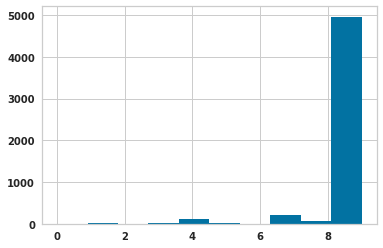

In [ ]:
# plot distribution for separate cluster groups- Percentage of samples present within a radius of x unit from cluster center
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)


num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:], exp_config.confidence_decay_factor)
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated(df)
total_confidence_of_wrong_annotation = get_sum_confidence_wrong(df)

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{epochs_completed}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

# Iteration 7

## Train model

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        root_path=root_path,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        num_units=exp_config.num_units)
tf.reset_default_graph()

{'NUM_UNITS': [16, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 3, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'LOG_LEVEL': 20, 'RUN_ID': 1, 'ID': 1, 'name': 'experiment_16_32'}
Loaded manual annotation
Nu

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/SemiSupervisedClassifierMnist.model-14960"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_32/Exp_0_32_16_10_ELBOW_1/trained_models/SemiSupervisedClassifierMnist.model-14960"
 
ckpt_name SemiSupervisedClassifierMnist.model-14960
INFO:tensorflow:R

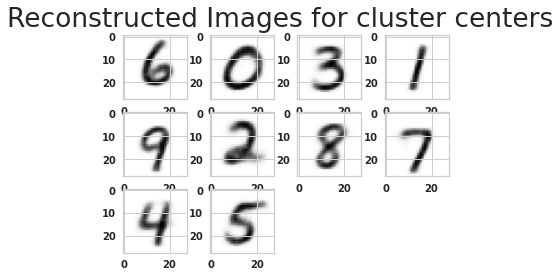

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                    )
display_images(decoded_images, image_filename, "Reconstructed Images for cluster centers")